In [1]:
import numpy as np
import os, sys, time
import matplotlib.pyplot as plt
import numba
import scipy.optimize
import scipy.signal
from scipy.optimize import leastsq, curve_fit
from scipy.stats import pearsonr
from scipy.signal import hilbert
from operator import itemgetter
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.signal import find_peaks
from matplotlib.collections import PolyCollection
# import imageio.v2 as imageio
from PIL import Image
import matplotlib.patches as mpatches
from scipy import integrate
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors

In [2]:
import os, subprocess
def svg_to_emf(svg_figpath):
    '''1. 如果是.svg的绝对路径，True改为False；
       2. inlscape.exe的文件路径中必须是双斜杠\\，单斜杠\会出错；
       3. subprocess.call中的shell=True不可省略，否则会报错。'''
    if True:
        cwd_path = os.getcwd()
        svg_figpath = os.path.join(cwd_path, svg_figpath)
        print(svg_figpath)
    inkscape_path = 'D:\\Pycharm\\Inkscape\\bin\\inkscape.exe' 
    if svg_figpath is not None:
        path, svgfigname = os.path.split(svg_figpath)
        figname, figform = os.path.splitext(svgfigname)
        emf_figpath = os.path.join(path, figname + '.emf')
        subprocess.call("{} {} -T -o {}".format(inkscape_path, svg_figpath, emf_figpath), shell=True)
        os.remove(svg_figpath)

def powerfit(x, ain1, bin1, cin1):
        return ain1*x**bin1 + cin1

def poly2fit(x, p1, p2, p3):
    y = p1*x**2 + p2*x + p3
    return y
def poly3fit(x, p1, p2, p3, p4):
    y = p1*x**3 + p2*x**2 + p3*x + p4
    return y

def poly1fit(x, p1, p2):
    y = p1*x + p2
    return y
def poly4fit(x, p1, p2, p3, p4, p5):
    y = p1*x**4 + p2*x**3 + p3*x**2 + p4*x + p5
    return y
def poly5fit(x, p1, p2, p3, p4, p5, p6):
    y = p1*x**5 + p2*x**4 + p3*x**3 + p4*x**2 + p5*x + p6
    return y

def gauss2fit(x, a1, b1, c1, a2, b2, c2):
    y = a1*np.exp(-((x-b1)/c1)**2) + a2*np.exp(-((x-b2)/c2)**2)
    return y
def gauss3fit(x, a1, b1, c1, a2, b2, c2, a3, b3, c3):
    y = a1*np.exp(-((x-b1)/c1)**2) + a2*np.exp(-((x-b2)/c2)**2) + a3*np.exp(-((x-b3)/c3)**2)
    return y
def gauss4fit(x, a1, b1, c1, a2, b2, c2, a3, b3, c3, a4, b4, c4):
    y = a1*np.exp(-((x-b1)/c1)**2) + a2*np.exp(-((x-b2)/c2)**2) + a3*np.exp(-((x-b3)/c3)**2) + a4*np.exp(-((x-b4)/c4)**2)
    return y

def exp2fit(x, a, b, c, d):
    y = a*np.exp(b*x) + c*np.exp(d*x)
    return y


@numba.njit
def generateOUNoise_Liu(tvar): 
    tau_OU = 5 # 5ms
    OUNoise = np.zeros_like(tvar)
    dt1 = tvar[1] - tvar[0] # ms
    for i in range(len(OUNoise)-1):
        OUNoise[i+1] = OUNoise[i] - (OUNoise[i]/tau_OU)*dt1 + np.sqrt(dt1)*np.sqrt(2/tau_OU)*np.random.randn()   
    return OUNoise
    
def calcSpikeNumberAndSpikeTimeAndFiringRate_IfSpike(vsoma, tvar, Vth=19.0):
    '''峰值时刻作为放电时刻'''
    risingBefore = np.hstack((0, vsoma[1:] - vsoma[:-1])) > 0  # v(t)-v(t-1)>0
    fallingAfter = np.hstack((vsoma[1:] - vsoma[:-1], 0)) < 0  # v(t)-v(t+1)<0
    localMaximum = np.logical_and(fallingAfter, risingBefore) # 逻辑与，上述两者逻辑与为真代表为局部最大值，是放电峰值可能存在的时刻
    largerThanThresh = vsoma > Vth  # 定义一个远大于放电阈值的电压值
    binarySpikeVector = np.logical_and(localMaximum,largerThanThresh) # 放电峰值时刻二进制序列
    spikeInds = np.nonzero(binarySpikeVector)
    spikeNumber = np.sum(binarySpikeVector)
    outputSpikeTimes = tvar[spikeInds]
    firingRate = 1e3 * spikeNumber / (tvar[-1] - tvar[0])
    return spikeNumber, firingRate, spikeInds, outputSpikeTimes

def calcSpikeTrainCorrelation(vsoma1, vsoma2, tvar, Tin=10, Vth=19.0):
    dt = tvar[1] - tvar[0]
    nDtPer1ms = int(1/dt)
    _, _, spikeIndex, _  = calcSpikeNumberAndSpikeTimeAndFiringRate_IfSpike(vsoma1, tvar, Vth=Vth)
    SpikeTimeSequence   = np.zeros_like(tvar)
    SpikeTimeSequence[spikeIndex] = 1.0
    binarySpikeSequence = SpikeTimeSequence.reshape(-1, nDtPer1ms) # 按照行reshape
    binarySpikeSequence = np.sum(binarySpikeSequence, axis=1)
    spikeCountSequence  = binarySpikeSequence.reshape(-1, int(Tin))
    spikeCountSequence1 = np.sum(spikeCountSequence, axis=1)

    _, _, spikeIndex, _  = calcSpikeNumberAndSpikeTimeAndFiringRate_IfSpike(vsoma2, tvar, Vth=Vth)
    SpikeTimeSequence   = np.zeros_like(tvar)
    SpikeTimeSequence[spikeIndex] = 1.0
    binarySpikeSequence = SpikeTimeSequence.reshape(-1, nDtPer1ms) # 按照行reshape
    binarySpikeSequence = np.sum(binarySpikeSequence, axis=1)
    spikeCountSequence  = binarySpikeSequence.reshape(-1, int(Tin))
    spikeCountSequence2 = np.sum(spikeCountSequence, axis=1)
    
    outputCorrelation   = pearsonr(spikeCountSequence1, spikeCountSequence2)[0]
    return outputCorrelation

def calcTacsSpikePLV(vsoma, Evar, tvar, Vth=19.0):
    '''采用希尔伯特变换, 0°对应了电场波形的峰值, 90°对应了电场下降边缘'''
    analyticSignal = hilbert(Evar)
    tacsInstantaneousPhase = np.angle(analyticSignal)  # 计算结果为弧度值,-π~π
    _, _, spikeIndex, spikeTime = calcSpikeNumberAndSpikeTimeAndFiringRate_IfSpike(vsoma, tvar, Vth=Vth)
    spikePhaseRadian = tacsInstantaneousPhase[spikeIndex]
    spikePhaseRadian[spikePhaseRadian < 0 ] += 2*np.pi
    pluralPLV = np.mean(np.exp(1j*spikePhaseRadian))
    spikePhaseDegree = np.rad2deg(spikePhaseRadian)
    fieldSpikePLV = np.abs(pluralPLV)
    
    return fieldSpikePLV, spikePhaseDegree, pluralPLV

'''
Paper: Weak electric fields promote resonance in neuronal spiking activity: Analytical results from two-compartment cell and network models
'''
@numba.njit
def twoCompModel(params2C, vs, vd, Is=0.0, Id=0.0, E=0.0, dt=0.1):
    # Cs, Cd, Gs, Gd, Gi = params2C['Cs'], params2C['Cd'], params2C['Gs'], params2C['Gd'], params2C['Gj']
    # Gexp, DeltaT, VT   = params2C['Gexp'], params2C['DeltaT'], params2C['VT']
    # # Vr, Vth            = params2C['Vr'], params2C['Vth']
    # Delta, DeltaV      = params2C['Delta'], params2C['DeltaV']
    Cs, Cd, Gs, Gd, Gi, Gexp, DeltaT, VT, Delta, DeltaV = params2C
    vsn = vs + dt * ( Gi*(vd-vs-Delta*E) - Gs*vs + Is + Gexp*DeltaT*np.exp((vs-VT)/DeltaT)) / Cs
    vdn = vd + dt * (-Gi*(vd-vs-Delta*E) - Gd*vd + Id) / Cd
    return vsn, vdn
    
@numba.njit
def runModel(params2C=np.ones(1), dt=0.01, tvar=0., Is=0.0, Id=0.0, Evar=0.0):
    Vr, Vth  = params2C[-2], params2C[-1]
    vs, vd   = 0, 0
    vsoma, vdend = np.zeros_like(tvar), np.zeros_like(tvar)
    for i, t in enumerate(tvar):
        vs, vd = twoCompModel(params2C[0:-2], vs, vd, Is=Is[i], Id=Id[i], E=Evar[i], dt=dt)
        if vs > Vth:
            vs = Vr
        vsoma[i], vdend[i] = vs, vd
        
    return vsoma, vdend

params2C = np.load('data/params2C.npy')
Cs, Cd, Gs, Gd, Gi, Gexp, DeltaT, VT, Delta, DeltaV, Vr, Vth = params2C

# Figure 1: 两间室神经元模型

(-0.5, 746.5, 471.5, -0.5)

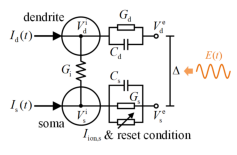

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
addr  = r'G:\GDesktop\Ph.D_2024\2_EffectOfTacsOnCorrelation\论文写作\PaperFigure\Figure1.tif'
photo = Image.open(addr)
ax.imshow(photo, origin='upper')
ax.set_xlim(ax.get_xlim()[0]-0, ax.get_xlim()[1]+0)
ax.set_ylim(ax.get_ylim()[0]+0, ax.get_ylim()[1]-0)
ax.axis('off')

# Figure 2: 相关性计算示意图

(-0.5, 1565.5, 458.5, -0.5)

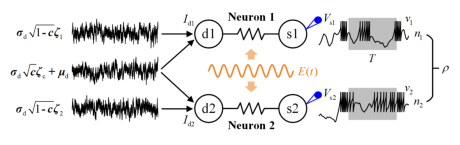

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
addr  = r'G:\GDesktop\Ph.D_2024\2_EffectOfTacsOnCorrelation\论文写作\PaperFigure\Figure2.tif'
photo = Image.open(addr)
ax.imshow(photo, origin='upper')
ax.set_xlim(ax.get_xlim()[0]-0, ax.get_xlim()[1]+0)
ax.set_ylim(ax.get_ylim()[0]+0, ax.get_ylim()[1]-0)
ax.axis('off')

# Figure 3: tACS能够改变放电相关性

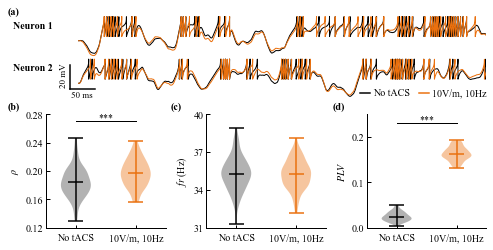

In [5]:
plt.rcParams.update({
    'font.size': 10,  
    'font.family': 'times new roman',
    'mathtext.fontset': 'stix',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic'
})
linewidth = 1
plt.rcParams['xtick.direction'] = 'in'   
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = linewidth
plt.rcParams['ytick.major.width'] = linewidth
labelpad = 1

fig = plt.figure(figsize=(7, 3.5))
shape0, shape1 = 9, 3
ax0 = plt.subplot2grid(shape=(shape0, shape1), loc=(0,0), rowspan=4, colspan=3)
ax1 = plt.subplot2grid(shape=(shape0, shape1), loc=(4,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid(shape=(shape0, shape1), loc=(4,1), rowspan=5, colspan=1)
ax3 = plt.subplot2grid(shape=(shape0, shape1), loc=(4,2), rowspan=5, colspan=1)

'''Figure 4(a): 有无电场作用下时序波形'''
data = np.load('data/figure4a_timesequence.npz')
vsoma1, vsoma2, vsoma3, vsoma4, tvar = data['vsoma1'], data['vsoma2'], data['vsoma3'], data['vsoma4'], data['tvar']
ax0.plot(tvar, vsoma1+35, color='k', lw=1)
ax0.plot(tvar, vsoma2,    color='k', lw=1)
ax0.plot(tvar, vsoma3+35, color='#EA700E', lw=1)
ax0.plot(tvar, vsoma4,    color='#EA700E', lw=1)
ax0.set_xlim(-80, 1000)
ax0.plot([-20, -20], [-5, 15], color='k', lw=1.5)
ax0.plot([-20, 40], [-5, -5], color='k', lw=1.5)
ax0.text(-45, -2, '20 mV', fontsize=9, rotation=90)
ax0.text(-18, -12, '50 ms', fontsize=9, rotation=0)
ax0.axis('off')
ax0.text(-160, 45, 'Neuron 1', fontsize=10, fontweight='bold')
ax0.text(-160, 10, 'Neuron 2', fontsize=10, fontweight='bold')
# square = plt.Rectangle(xy=(690, -13.5), width=310-1, height=12, fill=False, ec='grey', lw=0.5)
# ax0.add_patch(square)
ax0.plot([700-10, 730-15], [-8, -8], color='k', lw=1.5)
ax0.text(740-15-3, -10.5, 'No tACS', fontsize=10)

ax0.plot([850-15, 880-20], [-8, -8], color='#EA700E', lw=1.5)
ax0.text(890-20-3, -10.5, '10V/m, 10Hz', fontsize=10)


res     = np.load('data/times30_c03_mu14pA_sigma35pA_AE0-10_fE10.npy')
res     = res.squeeze() # shape=(times, AE, results)
data_rou= res[:, :, 2]  #shape=(times, AE)
data_fr = res[:, :, 1]
data_plv= res[:, :, 3]
'''Figure 4(b): 相关性——有无电场作用'''
positions = np.array([0, 1])
pc1 = ax1.violinplot(data_rou, positions=positions, showmeans=True)
ax1.set_xticks(positions, labels=['No tACS', '10V/m, 10Hz'], fontsize=10)
ax1.set_yticks(np.arange(0.12, 0.28+1, 0.04))
ax1.set_ylabel(r'$\rho$', fontsize=10)
ax1.set_ylim(0.12, 0.28)

'''Figure 4(c): 放电率——有无电场作用'''
pc2 = ax2.violinplot(data_fr, positions=positions, showmeans=True)
ax2.set_xticks(positions, labels=['No tACS', '10V/m, 10Hz'], fontsize=10)
ax2.set_yticks(np.arange(31, 41, 3))
ax2.set_ylabel('$fr$ (Hz)', fontsize=10)
ax2.set_ylim(31, 40)

'''Figure 4(d): PLV——有无电场作用'''
pc3 = ax3.violinplot(data_plv, positions=positions, showmeans=True)
ax3.set_xticks(positions, labels=['No tACS', '10V/m, 10Hz'], fontsize=10)
ax3.set_yticks(np.arange(0, 0.21, 0.1))
ax3.set_ylabel(r'$\mathit{PLV}$', fontsize=10)
ax3.set_ylim(0, 0.25)

for item in [ax1, ax2, ax3]:
    item.tick_params('y', pad=3)
    item.tick_params('x', pad=5)
    item.spines['top'].set_color('none')
    item.spines['right'].set_color('none')
    item.spines['bottom'].set_linewidth(linewidth)
    item.spines['left'].set_linewidth(linewidth)
    item.set_xlim(0-0.5, 1+0.5)

colors = ['grey', '#EA700E']
for pci in [pc1, pc2, pc3]:
    pci['cmeans'].set_color(['k', '#EA700E'])
    pci['cmaxes'].set_color(['k', '#EA700E'])
    pci['cmins'].set_color(['k', '#EA700E'])
    pci['cbars'].set_color(['k', '#EA700E'])

    pci['bodies'][0].set_facecolor('grey')
    pci['bodies'][0].set_alpha(0.6)
    pci['bodies'][1].set_facecolor('#EA700E')
    pci['bodies'][1].set_alpha(0.4)
plt.tight_layout(w_pad=1, h_pad=1)

ax1.plot([0, 1], [0.27, 0.27], lw=1, color='k')
ax1.text(0.38, .27, '***', fontsize=10)
ax3.plot([0, 1], [0.23, 0.23], lw=1, color='k')
ax3.text(0.38, .23, '***', fontsize=10)

fig.text(0.015, 0.95, '(a)', fontsize=10, fontweight='bold')
fig.text(0.015, 0.57, '(b)', fontsize=10, fontweight='bold')
fig.text(0.34, 0.57, '(c)', fontsize=10, fontweight='bold')
fig.text(0.66, 0.57, '(d)', fontsize=10, fontweight='bold')

# plt.savefig(r'C:\Users\Snowp\Desktop\figures\figure3.tif',format='tif',transparent=True,dpi=400,bbox_inches='tight')
plt.savefig(r'C:\Users\Snowp\Desktop\figures\figure3.png',format='png',transparent=True,dpi=400,bbox_inches='tight')

# Figure 4: 电场强度和电场频率对输出相关性的影响

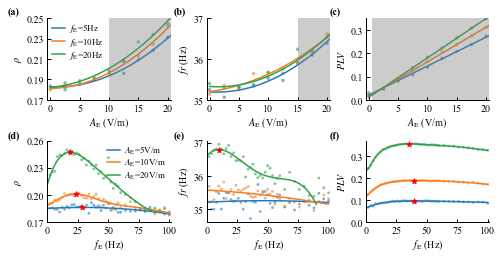

In [10]:
plt.rcParams.update({
    'font.size': 10,  
    'font.family': 'times new roman',
    'mathtext.fontset': 'stix',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic'
})
linewidth = 1
plt.rcParams['xtick.direction'] = 'in'   
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = linewidth
plt.rcParams['ytick.major.width'] = linewidth
labelpad = 3
lw = 1.5
fig, ax = plt.subplots(2, 3, figsize=(7, 3.6))
list_AE  = np.arange(0, 20+1, 2.5)
list_fE  = [5, 10, 20, 50]
res      = np.load('data/times50_c03_mu14pA_sigma35pA_AE0-20_fE5-10-20-50.npy')
res      = res.squeeze() # shape=(times, AE, fE, results)
data_rou = res.transpose(3, 2, 0, 1)[2]  # (fE, times, AE)
data_fr  = res.transpose(3, 2, 0, 1)[1]
data_plv = res.transpose(3, 2, 0, 1)[3]
size=12
alpha=0.6
colors = ['#247AB7', '#F47E1F', '#30A04A']
for i in [0, 1, 2]:
    x, y = list_AE, data_rou[i].mean(axis=0)
    init_values = [0.1 for i in range(3)]
    best_vals, covar = curve_fit(poly2fit, x, y, p0=init_values, maxfev = 1000000)
    xfit        = np.arange(0, 21, 0.01)
    yfit        = poly2fit(xfit, *best_vals)
    ax[0, 0].scatter(list_AE, data_rou[i].mean(axis=0), marker='o', s=size, color=colors[i], ec=None, alpha=alpha, zorder=-1)
    ax[0, 0].plot(xfit, yfit, color=colors[i], zorder=1, lw=lw, label=r'$\mathit{f}_{\mathrm{E}}$=%dHz' % list_fE[i])
    
    x, y = list_AE, data_fr[i].mean(axis=0)
    init_values = [0.1 for i in range(3)]
    best_vals, covar = curve_fit(poly2fit, x, y, p0=init_values, maxfev = 1000000)
    xfit        = np.arange(0, 21, 0.01)
    yfit        = poly2fit(xfit, *best_vals)
    ax[0, 1].scatter(list_AE, data_fr[i].mean(axis=0), marker='o', s=size, color=colors[i], ec=None, alpha=alpha, zorder=-1)
    ax[0, 1].plot(xfit, yfit, color=colors[i], zorder=1, lw=lw)

    x, y = list_AE, data_plv[i].mean(axis=0)
    init_values = [0.1 for i in range(2)]
    best_vals, covar = curve_fit(poly1fit, x, y, p0=init_values, maxfev = 1000000)
    xfit        = np.arange(0, 21, 0.01)
    yfit        = poly1fit(xfit, *best_vals)
    ax[0, 2].scatter(list_AE, data_plv[i].mean(axis=0), marker='o', s=size, color=colors[i], ec=None, alpha=alpha, zorder=-1)
    ax[0, 2].plot(xfit, yfit, color=colors[i], zorder=1, lw=lw)

ax[0, 0].legend(fontsize=9, frameon=False, labelspacing=0.15, handletextpad=0.4, borderpad=0.5, handlelength=1.5, borderaxespad=0)
ax[0, 0].set_ylim(0.17, 0.25)
ax[0, 0].set_yticks(np.arange(0.17, 0.26, 0.02))
ax[0, 1].set_ylim(35, 37)
ax[0, 1].set_yticks(np.arange(35, 37.1, 1))
ax[0, 2].set_ylim(0, 0.35)
ax[0, 2].set_yticks(np.arange(0, 0.35, 0.1))

coordinate = np.array([[10, 0.17], [21, 0.17], [21, 0.25], [10, 0.25]])
polycol = PolyCollection([coordinate, ], closed=True, edgecolor=None, facecolor='grey', alpha=0.4)
ax[0, 0].add_collection(polycol)
coordinate = np.array([[15, 35], [21, 35], [21, 37], [15, 37]])
polycol = PolyCollection([coordinate, ], closed=True, edgecolor=None, facecolor='grey', alpha=0.4)
ax[0, 1].add_collection(polycol)
coordinate = np.array([[0.5, 0], [21, 0], [21, 0.35], [0.5, 0.35]])
polycol = PolyCollection([coordinate, ], closed=True, edgecolor=None, facecolor='grey', alpha=0.4)
ax[0, 2].add_collection(polycol)
                         
list_AE = [5, 10, 20]
list_fE = np.hstack((np.arange(2, 60, 2), np.arange(60, 101, 4)))
res      = np.load('data/times50_c03_mu14pA_sigma35pA_AE5-10-20_fE2-100.npy')
res      = res.squeeze() # shape=(times, AE, fE, results)
data_rou = res.transpose(3, 1, 0, 2)[2]  # (fE, times, AE)
data_fr  = res.transpose(3, 1, 0, 2)[1]
data_plv = res.transpose(3, 1, 0, 2)[3]
starsize=30
size=8
alpha=0.6
for i in [0, 1]:
    x, y = list_fE, data_rou[i].mean(axis=0)
    init_values = [10 for i in range(6)]
    best_vals, covar = curve_fit(gauss2fit, x, y, p0=init_values, maxfev = 1000000)
    xfit        = np.arange(0, 100, 0.1)
    yfit        = gauss2fit(xfit, *best_vals)
    ax[1, 0].scatter(list_fE, data_rou[i].mean(axis=0), marker='o', s=size, color=colors[i], zorder=-1, alpha=alpha, ec=None)
    ax[1, 0].plot(xfit, yfit, color=colors[i], zorder=0, lw=1.5, label=r'$\mathit{A}_{\mathrm{E}}$=%dV/m' % list_AE[i])
    ax[1, 0].scatter(xfit[np.argmax(yfit)], yfit.max(), marker='*', s=starsize, facecolor='r', zorder=1)
i=2
x, y = list_fE, data_rou[i].mean(axis=0)
init_values = [0.1 for i in range(6)]
best_vals, covar = curve_fit(poly5fit, x, y, p0=init_values, maxfev = 1000000)
xfit        = np.arange(0, 91, 0.1)
yfit        = poly5fit(xfit, *best_vals)
ax[1, 0].scatter(list_fE, data_rou[i].mean(axis=0), marker='o', s=size, color=colors[i], zorder=-1, alpha=alpha, ec=None)
ax[1, 0].plot(xfit, yfit, color=colors[i], zorder=0, lw=1.5, label=r'$\mathit{A}_{\mathrm{E}}$=%dV/m' % list_AE[i])
ax[1, 0].scatter(xfit[np.argmax(yfit)], yfit.max(), marker='*', s=starsize, facecolor='r', zorder=1)
ax[1, 0].legend(fontsize=9, frameon=False, labelspacing=0.15, handletextpad=0.4, borderpad=0.5, handlelength=1.5, borderaxespad=0)


for i in [0, 1]: 
    x, y = list_fE, data_fr[i].mean(axis=0)
    init_values = [0.1 for i in range(3)]
    best_vals, covar = curve_fit(poly2fit, x, y, p0=init_values, maxfev = 1000000)
    xfit        = np.arange(0, 100, 0.1)
    yfit        = poly2fit(xfit, *best_vals)
    ax[1, 1].scatter(list_fE, data_fr[i].mean(axis=0), marker='o', s=size, color=colors[i], ec=None, zorder=-1, alpha=alpha)
    ax[1, 1].plot(xfit, yfit, color=colors[i], zorder=0, lw=1.5)
i=2
x, y = list_fE, data_fr[i].mean(axis=0)
x, y = x[:-3], y[:-3]
init_values = [10 for i in range(6)]
best_vals, covar = curve_fit(gauss2fit, x, y, p0=init_values, maxfev = 1000000)
xfit        = np.arange(0, 90, 0.1)
yfit        = gauss2fit(xfit, *best_vals)
ax[1, 1].scatter(list_fE, data_fr[i].mean(axis=0), marker='o', s=size, color=colors[i], ec=None, zorder=-1, alpha=alpha)
ax[1, 1].plot(xfit, yfit, color=colors[i], zorder=0, lw=1.5)
ax[1, 1].scatter(xfit[np.argmax(yfit)], yfit.max(), marker='*', s=starsize, facecolor='r', zorder=1)

templist = [8, 10, 20]
for i in [0, 1, 2]:
    x, y = list_fE, data_plv[i].mean(axis=0)
    init_values = [templist[i] for j in range(12)]
    best_vals, covar = curve_fit(gauss4fit, x, y, p0=init_values, maxfev = 1000000)
    xfit        = np.arange(0, 100, 0.1)
    yfit        = gauss4fit(xfit, *best_vals)
    ax[1, 2].scatter(list_fE, data_plv[i].mean(axis=0), marker='o', s=size, color=colors[i], ec=None, zorder=-1, alpha=alpha)
    ax[1, 2].plot(xfit, yfit, color=colors[i], zorder=0, lw=1.5)
    ax[1, 2].scatter(xfit[np.argmax(yfit)], yfit.max(), marker='*', s=starsize, facecolor='r', zorder=1)


ax[1, 0].set_ylim(0.17, 0.26)
ax[1, 0].set_yticks(np.arange(0.17, 0.27, 0.03))
# ax[1, 1].set_ylim(35, 37)
# ax[1, 1].set_yticks(np.arange(35, 37.1, 1))
ax[1, 2].set_ylim(0, )
ax[1, 2].set_yticks(np.arange(0, 0.35, 0.1))



for i in range(2):
    ax[i, 0].set_ylabel(r'$\rho$', fontsize=10, labelpad=labelpad)
    ax[i, 1].set_ylabel(r'$fr$ (Hz)', fontsize=10, labelpad=labelpad)
    ax[i, 2].set_ylabel(r'$\mathit{PLV}$', fontsize=10, labelpad=labelpad)
    
for j in range(3):
    ax[0, j].set_xlabel(r'$\mathit{A}_{\mathrm{E}}$ (V/m)', fontsize=10, labelpad=labelpad)
    ax[0, j].set_xlim(-0.5, 20.5)
    ax[0, j].set_xticks(np.arange(0, 21, 5))
    ax[0, j].tick_params(pad=3)

for j in range(3):
    ax[1, j].set_xlabel(r'$\mathit{f}_{\mathrm{E}}$ (Hz)', fontsize=10, labelpad=labelpad)
    ax[1, j].set_xlim(0, 101)
    ax[1, j].set_xticks(np.arange(0, 101, 25))
    ax[1, j].tick_params(pad=3)

for i in range(2):
    for j in range(3):
        ax[i, j].spines['top'].set_color('none')
        ax[i, j].spines['right'].set_color('none')
        ax[i, j].spines['bottom'].set_linewidth(linewidth)
        ax[i, j].spines['left'].set_linewidth(linewidth)

plt.tight_layout(w_pad=0, h_pad=0.7)
fig.text(0.01, 0.96, '(a)', fontsize=10, fontweight='bold')
fig.text(0.34, 0.96, '(b)', fontsize=10, fontweight='bold')
fig.text(0.65, 0.96, '(c)', fontsize=10, fontweight='bold')
fig.text(0.01, 0.48, '(d)', fontsize=10, fontweight='bold')
fig.text(0.34, 0.48, '(e)', fontsize=10, fontweight='bold')
fig.text(0.65, 0.48, '(f)', fontsize=10, fontweight='bold')
# plt.savefig(r'C:\Users\Snowp\Desktop\figures\figure4.tif',format='tif',transparent=True,dpi=400,bbox_inches='tight')
plt.savefig(r'C:\Users\Snowp\Desktop\figures\figure4.png',format='png',transparent=True,dpi=400,bbox_inches='tight')

# Figure 5: PLV是影响输出相关性的因素之一

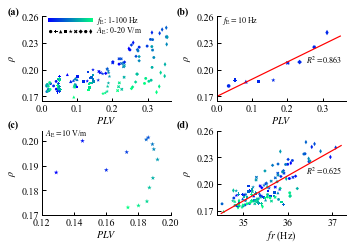

In [11]:
plt.rcParams.update({
    'font.size': 10,  
    'font.family': 'times new roman',
    'mathtext.fontset': 'stix',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic'
})
linewidth = 1
plt.rcParams['xtick.direction'] = 'in'   
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = linewidth
plt.rcParams['ytick.major.width'] = linewidth

fig, ax = plt.subplots(2, 2, figsize=(5, 3.5))
ax0, ax1, ax2, ax3 = ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1]

list_AE = np.arange(0, 20+1, 2.5)
list_fE = [2, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]
res     = np.load('data/times30_c03_mu14pA_sigma35pA_AE0-20_fE2-100.npy')
res     = res.squeeze().mean(axis=0).transpose(2, 0, 1)
data_rou, data_fr, data_plv = res[2], res[1], res[3]
colorLength = len(list_fE)
list_color0 = plt.cm.get_cmap('winter', lut=colorLength)  # bwr, seismic, cool
colors = [list_color0(i) for i in range(colorLength)]
markerList = ['o', 'P', '^','s', '*', 'X', 'D', 'H', 'd']
markerSizeList = np.array([3, 6, 4, 1, 10, 5, 1, 5, 5]) + 5

'''Figure 5(a): 输出相关性——PLV之间关系'''
for i in range(len(list_AE)):
    for j in range(len(list_fE)):
        ax0.scatter(data_plv[i, j], data_rou[i, j], marker=markerList[i], s=markerSizeList[i], color=colors[j], ec=None)
ax0.set_ylim(0.165, 0.26)
ax0.set_yticks(np.arange(0.17, 0.261, 0.03))
ax0.set_xlim(0, 0.365)
########################################################################################################################
########################################################################################################################
'''Figure 5(b): 相关性——plv,10Hz电场条件'''
x = data_plv[:, 2]
y = data_rou[:, 2]
xfit = np.arange(0, 0.36, 0.01)
yfit = poly1fit(xfit, *[0.1942, 0.1699])
for i in range(len(x)):
    ax1.scatter(x[i], y[i], marker=markerList[i], s=markerSizeList[i] + 5, color=colors[2], ec=None)
ax1.plot(xfit, yfit, color='r', lw=1.2)
ax1.set_ylim(0.165, 0.26)
ax1.set_yticks(np.arange(0.17, 0.261, 0.03))
ax1.set_xlim(0, 0.365)
ax1.text(0.254, 0.207, r'$R^2=0.863$', fontsize=8)
########################################################################################################################
########################################################################################################################
'''Figure 5(c): 相关性——plv,10V电场条件'''
x = data_plv[4, :]
y = data_rou[4, :]
for j in range(len(x)):
    ax2.scatter(x[j], y[j], marker=markerList[4], s=markerSizeList[4] + 8, color=colors[j], ec=None)
ax2.set_ylim(0.17, 0.204)
ax2.set_xlim(0.12, 0.20)
ax2.set_xticks([0.12, 0.14, 0.16, 0.18, 0.20])
########################################################################################################################
########################################################################################################################
'''Figure 5(d): 相关性——放电率关系'''
for i in range(len(list_AE)):
    for j in range(len(list_fE)):
        ax3.scatter(data_fr[i, j], data_rou[i, j], marker=markerList[i], s=markerSizeList[i], color=colors[j], ec=None)

x, y = data_fr.flatten(), data_rou.flatten()
xtemp       = sorted(enumerate(x), key=itemgetter(1))
xindex      = map(itemgetter(0), xtemp)
multi_piker = itemgetter(*xindex)
xsort = np.array(multi_piker(x))
ysort = np.array(multi_piker(y))
init_values = [0.1 for i in range(2)]
best_vals, covar = curve_fit(poly1fit, xsort, ysort, p0=init_values, maxfev = 1000000)
xfit        = np.arange(34.5, 37.2, 0.01)
yfit        = poly1fit(xfit, *best_vals)
ax3.plot(xfit, yfit, color='r', lw=1.2)

ax3.set_ylim(0.165, 0.26)
ax3.set_yticks(np.arange(0.17, 0.261, 0.03))
ax3.set_xlim(34.4, 37.3)
ax3.text(36.4, 0.21, r'$R^2=0.625$', fontsize=8)
########################################################################################################################
########################################################################################################################



for item in [ax0, ax1, ax2, ax3]:
    item.tick_params(pad=3)
    item.spines['top'].set_color('none')
    item.spines['right'].set_color('none')
    item.spines['bottom'].set_linewidth(linewidth)
    item.spines['left'].set_linewidth(linewidth)
    item.set_ylabel(r'$\rho$', fontsize=10, labelpad=3)
ax0.set_xlabel(r'$\mathit{PLV}$', fontsize=10, labelpad=1)
ax1.set_xlabel(r'$\mathit{PLV}$', fontsize=10, labelpad=1)
ax2.set_xlabel(r'$\mathit{PLV}$', fontsize=10, labelpad=1)
ax3.set_xlabel(r'$fr$ (Hz)', fontsize=10, labelpad=1)

plt.tight_layout(w_pad=0.3, h_pad=0.1)

fig.text(0.03, 0.95, '(a)', fontsize=10, fontweight='bold')
fig.text(0.50, 0.95, '(b)', fontsize=10, fontweight='bold')
fig.text(0.03, 0.5, '(c)', fontsize=10, fontweight='bold')
fig.text(0.50, 0.5, '(d)', fontsize=10, fontweight='bold')
###################################################
###################################################
list_AE = np.arange(0, 20+1, 2.5)
list_fE = np.array([2, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100])
ax0in = ax0.inset_axes([0.05, 0.93, 0.35, 0.05])
norm = Normalize(vmin=1, vmax=100)
cmap = plt.cm.get_cmap('winter')
scalar_mappable = ScalarMappable(cmap=cmap, norm=norm)
cbar0 = plt.colorbar(scalar_mappable, cax=ax0in, orientation='horizontal', ticks=[])
ax0in.axis('off')

ax0in1 = ax0.inset_axes([0.05, 0.77, 0.35, 0.1])
ax0in1.set_xlim(-0.5, 8.5)
ax0in1.set_ylim(0, 1)
for i in range(len(list_AE)):
    ax0in1.scatter(i, 0.5, marker=markerList[i], s=markerSizeList[i]+3, color='k', ec=None)
ax0in1.axis('off')

ax0.text(0.155, 0.253, r'$\mathit{f}_{\mathrm{E}}$: 1-100 Hz', fontsize=8)
ax0.text(0.155, 0.241, r'$\mathit{A}_{\mathrm{E}}$: 0-20 V/m', fontsize=8)
ax1.text(0.015, 0.253, r'$\mathit{f}_{\mathrm{E}}=10$ Hz', fontsize=8)
ax2.text(0.122, 0.2018, r'$\mathit{A}_{\mathrm{E}}=10$ V/m', fontsize=8)

# plt.savefig(r'C:\Users\Snowp\Desktop\figures\figure5.tif',format='tif',transparent=True,dpi=400,bbox_inches='tight')
plt.savefig(r'C:\Users\Snowp\Desktop\figures\figure5.png',format='png',transparent=True,dpi=400,bbox_inches='tight')

# Figure 6: tACS调节输入相关性是影响输出相关性的又一重要因素

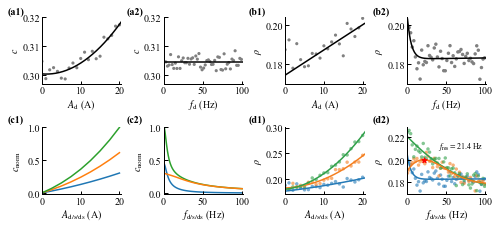

In [12]:
plt.rcParams.update({
    'font.size': 10,  
    'font.family': 'times new roman',
    'mathtext.fontset': 'stix',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic'
})
linewidth = 1
plt.rcParams['xtick.direction'] = 'in'   
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = linewidth
plt.rcParams['ytick.major.width'] = linewidth
colors = ['#247AB7', '#F47E1F', '#30A04A']
fig, ax = plt.subplots(2, 4, figsize=(7, 3.2))

########################################################################################
########################################################################################
list_AE = np.arange(0, 21, 1)
list_fE = np.arange(1, 100, 2)
'''Figure 6(a): 正弦刺激强度改变输入相关性'''
data = np.load('data/onlyDendriticSineWave_times40_c03_mu14pA_sigma35pA_AE0-20_fE10.npy')
data = data.squeeze().mean(axis=0).transpose()
data_c = data[0]
xfit   = np.arange(0, 20.5, 0.01)
yfit   = poly2fit(xfit, *[4.799e-5, -0.0001067, 0.3004])
ax[0, 0].scatter(list_AE, data_c, s=10, ec=None, fc='grey')
ax[0, 0].plot(xfit, yfit, color='k', lw=1.5)

ax[0, 0].set_ylim(0.297, 0.32)

'''Figure 6(b): 正弦刺激频率不改变输入相关性'''
data = np.load('data/onlyDendriticSineWave_times40_c03_mu14pA_sigma35pA_AE10_fE1-100.npy')
data = data.squeeze().mean(axis=0).transpose()
data_c = data[0]
ax[0, 1].scatter(list_fE, data_c, s=10, ec=None, fc='grey')
ax[0, 1].set_ylim(0.297, 0.32)
ax[0, 1].plot([0, 101], [data_c.mean(), data_c.mean()], color='k', lw=1.5)
########################################################################################
########################################################################################
'''Figure 6(c): 输出相关性依赖于刺激强度'''
data = np.load('data/onlyDendriticSineWave_times40_c03_mu14pA_sigma35pA_AE0-20_fE10.npy')
data = data.squeeze().mean(axis=0).transpose()
data_rou = data[2]
xfit   = np.arange(0, 20.5, 0.01)
yfit   = poly1fit(xfit, *[0.001283, 0.1744])
ax[0, 2].scatter(list_AE, data_rou, s=10, ec=None, fc='grey')
ax[0, 2].plot(xfit, yfit, color='k', lw=1.5)

'''Figure 6(d): 输出相关性依赖于刺激频率'''
data = np.load('data/onlyDendriticSineWave_times40_c03_mu14pA_sigma35pA_AE10_fE1-100.npy')
data = data.squeeze().mean(axis=0).transpose()
data_rou = data[2]
xfit   = np.arange(1, 100.5, 0.1)
yfit   = exp2fit(xfit, *[0.02485, -0.2023, 0.1826, 3.028e-5])
ax[0, 3].scatter(list_fE, data_rou, s=12, ec=None, fc='grey')
ax[0, 3].plot(xfit, yfit, color='k', lw=1.5)

########################################################################################
########################################################################################
'''Figure 6(e): 三种条件下刺激强度影响输入相关性'''
addr = ['data/dendSineAmp0-20_Freq10.npz', 'data/somadendSineAmp0-20_Freq10.npz', 'data/somaSineAmp0-20_Freq10.npz']
temp = np.array([])
for tempaddr in addr:
    data = np.load(tempaddr)
    list_AE, list_Ap = data['list_AE'], data['list_Ap']
    yfit = poly3fit(list_Ap, *[8.916e-7, 1.99e-5, 0.000135, 0.2999])
    temp = np.hstack((temp, yfit))
tempmax = temp.max()
tempmin = temp.min()
for tempaddr in addr:
    data = np.load(tempaddr)
    list_AE, list_Ap = data['list_AE'], data['list_Ap']
    yfit   = poly3fit(list_Ap, *[8.916e-7, 1.99e-5, 0.000135, 0.2999])
    yfit = (yfit-tempmin)/(tempmax-tempmin)
    ax[1, 0].plot(list_AE, yfit, lw=1.5)
'''Figure 6(f): 三种条件下刺激频率影响输入相关性'''
data_fig7b_norm_c = []
addr = ['data/dendSineAmp10_Freq1-100.npz', 'data/somadendSineAmp10_Freq1-100.npz', 'data/somaSineAmp10_Freq1-100.npz']
zorders = [-2, 1, 0]
temp = np.array([])
for tempaddr in addr:
    data = np.load(tempaddr)
    list_Ap = data['list_Ap']
    yfit = poly3fit(list_Ap, *[8.916e-7, 1.99e-5, 0.000135, 0.2999])
    temp = np.hstack((temp, yfit))
tempmax = temp.max()
tempmin = temp.min()
for i, tempaddr in enumerate(addr):
    data = np.load(tempaddr)
    list_fE, list_Ap = data['list_fE'], data['list_Ap']
    yfit   = poly3fit(list_Ap, *[8.916e-7, 1.99e-5, 0.000135, 0.2999])
    yfit = (yfit-tempmin)/(tempmax-tempmin)
    data_fig7b_norm_c.append([list_fE, (yfit-yfit.min())/(yfit.max()-yfit.min())])
    ax[1, 1].plot(list_fE, yfit, lw=1.5, zorder=zorders[i])

########################################################################################
########################################################################################
'''Figure 6(g): 三种条件下刺激强度影响输出相关性'''
list_AE = np.arange(0, 21, 1)
list_fE = np.arange(1, 100, 2)
addr = ['data/onlyDendriticSineWave_times40_c03_mu14pA_sigma35pA_AE0-20_fE10.npy',
        'data/SomaticAndDendriticSineWave_times40_c03_mu14pA_sigma35pA_AE0-20_fE10.npy',
        'data/onlySomaticSineWave_times40_c03_mu14pA_sigma35pA_AE0-20_fE10.npy']
paras = [[1.733e-5, 0.0008905, 0.1762], [0.0001404, 0.0003203, 0.1823], [0.000223, 0.0008241, 0.1799]]
xfit = np.arange(0, 21, 0.1)
for i, tempaddr in enumerate(addr):
    data = np.load(tempaddr)
    data = data.squeeze().mean(axis=0).transpose()
    data_rou = data[2]
    yfit = poly2fit(xfit, *paras[i])
    ax[1, 2].scatter(list_AE, data_rou, marker='o', s=12, color=colors[i], ec=None, alpha=0.6, zorder=-1)
    ax[1, 2].plot(xfit, yfit, color=colors[i], zorder=1, lw=1.5)

'''Figure 6(h): 三种条件下刺激频率影响输出相关性'''
addr = ['data/onlyDendriticSineWave_times40_c03_mu14pA_sigma35pA_AE10_fE1-100.npy',
        'data/SomaticAndDendriticSineWave_times40_c03_mu14pA_sigma35pA_AE10_fE1-100.npy',
        'data/onlySomaticSineWave_times40_c03_mu14pA_sigma35pA_AE10_fE1-100.npy']
xfit = np.arange(0, 101, 0.5)
yfit = []
yfit.append(exp2fit(xfit, *[0.02485, -0.2023, 0.1826, 3.028e-5]))
yfit.append(poly4fit(xfit, *[-1.258e-9, 3.762e-7, -3.736e-5, 0.001131, 0.1895]))
yfit.append(poly2fit(xfit, *[3.062e-6, -0.0007302, 0.2211]))
zorders=[1, 2, 1]
for i, tempaddr in enumerate(addr):
    data = np.load(tempaddr)
    data = data.squeeze().mean(axis=0).transpose()
    data_rou = data[2]
    ax[1, 3].scatter(list_fE, data_rou, marker='o', s=12, color=colors[i], ec=None, alpha=0.6, zorder=-1)
    ax[1, 3].plot(xfit, yfit[i], color=colors[i], zorder=zorders[i], lw=1.5)

xfit = np.arange(0, 101, 0.1)
yfit = poly4fit(xfit, *[-1.258e-9, 3.762e-7, -3.736e-5, 0.001131, 0.1895])
ax[1, 3].scatter(xfit[np.argmax(yfit)], yfit.max(), marker='*', s=30, facecolor='r', zorder=5)
ax[1, 3].text(40, 0.21, r'$f_\mathrm{res}=$%.1f Hz' % xfit[np.argmax(yfit)], fontsize=8)


########################################################################################
########################################################################################
for item in [ax[0,0], ax[0,2], ax[1,0], ax[1,2]]:
    item.set_xlim(0, 20.5)
    item.set_xticks(np.arange(0, 21, 10))

for item in [ax[0,1], ax[0,3], ax[1,1], ax[1,3]]:
    item.set_xlim(0, 101)
    item.set_xticks(np.arange(0, 101, 50))
ax[0, 2].set_ylim(0.17, 0.204)
ax[0, 3].set_ylim(0.17, 0.204)
for i in [0, 1]:
    ax[1, i].set_ylim(-0.02, 1)
    ax[1, i].set_yticks([0, 0.5, 1])

for i in range(2):
    for j in range(4):
        ax[i, j].tick_params(pad=2)
        ax[i, j].spines['top'].set_color('none')
        ax[i, j].spines['right'].set_color('none')
        ax[i, j].spines['bottom'].set_linewidth(linewidth)
        ax[i, j].spines['left'].set_linewidth(linewidth)

for i in [0, 1]:
    ax[i, 2].set_ylabel(r'$\rho$', fontsize=10, labelpad=2)
    ax[i, 3].set_ylabel(r'$\rho$', fontsize=10, labelpad=2)
ax[0, 0].set_xlabel(r'$\mathit{A}_{\mathrm{d}}$ (A)', fontsize=10, labelpad=2)
ax[0, 1].set_xlabel(r'$\mathit{f}_{\mathrm{d}}$ (Hz)', fontsize=10, labelpad=2)
ax[0, 2].set_xlabel(r'$\mathit{A}_{\mathrm{d}}$ (A)', fontsize=10, labelpad=2)
ax[0, 3].set_xlabel(r'$\mathit{f}_{\mathrm{d}}$ (Hz)', fontsize=10, labelpad=2)
ax[1, 0].set_xlabel(r'$\mathit{A}_{\mathrm{d/s/ds}}$ (A)', fontsize=10, labelpad=2)
ax[1, 1].set_xlabel(r'$\mathit{f}_{\mathrm{d/s/ds}}$ (Hz)', fontsize=10, labelpad=2)
ax[1, 2].set_xlabel(r'$\mathit{A}_{\mathrm{d/s/ds}}$ (A)', fontsize=10, labelpad=2)
ax[1, 3].set_xlabel(r'$\mathit{f}_{\mathrm{d/s/ds}}$ (Hz)', fontsize=10, labelpad=2)
ax[0, 0].set_ylabel(r'$c$', fontsize=10, labelpad=2)
ax[0, 1].set_ylabel(r'$c$', fontsize=10, labelpad=2)
ax[1, 0].set_ylabel(r'$\mathit{c}_{\mathrm{norm}}$', fontsize=10, labelpad=4)
ax[1, 1].set_ylabel(r'$\mathit{c}_{\mathrm{norm}}$', fontsize=10, labelpad=4)


########################################################################################
########################################################################################
plt.tight_layout(w_pad=0.3, h_pad=1.2)
fig.text(0.015, 0.95, '(a1)', fontsize=10, fontweight='bold')
fig.text(0.252, 0.95, '(a2)', fontsize=10, fontweight='bold')

fig.text(0.494, 0.95, '(b1)', fontsize=10, fontweight='bold')
fig.text(0.74, 0.95, '(b2)', fontsize=10, fontweight='bold')

fig.text(0.015, 0.48, '(c1)', fontsize=10, fontweight='bold')
fig.text(0.252, 0.48, '(c2)', fontsize=10, fontweight='bold')

fig.text(0.494, 0.48, '(d1)', fontsize=10, fontweight='bold')
fig.text(0.74, 0.48, '(d2)', fontsize=10, fontweight='bold')

# plt.savefig(r'C:\Users\Snowp\Desktop\figures\figure6.tif',format='tif',transparent=True,dpi=400,bbox_inches='tight')
plt.savefig(r'C:\Users\Snowp\Desktop\figures\figure6.png',format='png',transparent=True,dpi=400,bbox_inches='tight')

# Figure 7: 解释：电场通过输入相关性和PLV影响输出相关性

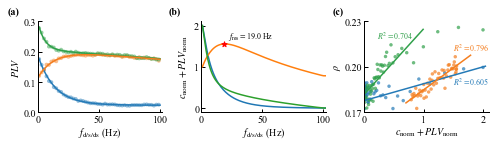

In [13]:
plt.rcParams.update({
    'font.size': 10,  
    'font.family': 'times new roman',
    'mathtext.fontset': 'stix',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic'
})
linewidth = 1
plt.rcParams['xtick.direction'] = 'in'   
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = linewidth
plt.rcParams['ytick.major.width'] = linewidth
colors = ['#247AB7', '#F47E1F', '#30A04A']
fig, ax = plt.subplots(1, 3, figsize=(7, 2))
ax0, ax1, ax2 = ax
#############################################################
#############################################################
list_AE = np.arange(0, 21, 1)
list_fE = np.arange(1, 100, 2)
'''Figure 7(a): 三种条件下的PLV-f曲线'''
addr = ['data/onlyDendriticSineWave_times40_c03_mu14pA_sigma35pA_AE10_fE1-100.npy',
        'data/SomaticAndDendriticSineWave_times40_c03_mu14pA_sigma35pA_AE10_fE1-100.npy',
        'data/onlySomaticSineWave_times40_c03_mu14pA_sigma35pA_AE10_fE1-100.npy']
xfit = np.arange(1, 101, 1)
yfit = []
yfit.append(exp2fit(xfit, *[0.163, -0.07286, 0.02392, -0.0004041]))
yfit.append(exp2fit(xfit, *[0.2086, -0.001764, -0.0945, -0.07626]))
yfit.append(exp2fit(xfit, *[0.08848, -0.1797, 0.2074, -0.001602]))
temp = np.array([])
for item in yfit:
    temp = np.hstack((temp, item))
tempmax = temp.max()
tempmin = temp.min()
zorders = [1, 2, 1]
data_fig7b_norm_plv = []
for i, tempaddr in enumerate(addr):
    data = np.load(tempaddr)
    data = data.squeeze().mean(axis=0).transpose()
    data_plv = data[3]
    data_fig7b_norm_plv.append([xfit, (yfit[i] - yfit[i].min())/(yfit[i].max()-yfit[i].min())])
    ax0.scatter(list_fE, data_plv, marker='o', s=15, color=colors[i], ec=None, alpha=0.5, zorder=-1)
    ax0.plot(xfit, yfit[i], color=colors[i], zorder=zorders[i], lw=1.5)
ax0.set_ylim(0, 0.3)
#############################################################
#############################################################
'''Figure 7(b): 三种条件下的PLV-f曲线'''
xfit = np.arange(1, 102, 0.1)
for i in range(3):
    cnorm = np.interp(xfit, data_fig7b_norm_c[i][0], data_fig7b_norm_c[i][1])
    plvnorm = np.interp(xfit, data_fig7b_norm_plv[i][0], data_fig7b_norm_plv[i][1])
    ax1.plot(xfit, cnorm + plvnorm, lw=1.5)
i = 1
yfit = np.interp(xfit, data_fig7b_norm_c[i][0], data_fig7b_norm_c[i][1]) + np.interp(xfit, data_fig7b_norm_plv[i][0], data_fig7b_norm_plv[i][1])
ax1.scatter(xfit[np.argmax(yfit)], yfit.max(), marker='*', s=30, facecolor='r', zorder=5)
ax1.text(22, 1.7, r'$f_\mathrm{res}=$%.1f Hz' % xfit[np.argmax(yfit)], fontsize=8)


#############################################################
#############################################################
'''Figure 7(c): 三种条件下的ρ-c+plv曲线'''
data_fig7b_norm_c = []
addr = ['data/dendSineAmp10_Freq1-100.npz', 'data/somadendSineAmp10_Freq1-100.npz', 'data/somaSineAmp10_Freq1-100.npz']
for i, tempaddr in enumerate(addr):
    data = np.load(tempaddr)
    list_fE, list_Ap = data['list_fE'], data['list_Ap']
    yfit   = poly3fit(list_Ap, *[8.916e-7, 1.99e-5, 0.000135, 0.2999])
    data_fig7b_norm_c.append([list_fE, (yfit-yfit.min())/(yfit.max()-yfit.min())])

xfit = np.arange(1, 100, 2)
addr = ['data/onlyDendriticSineWave_times40_c03_mu14pA_sigma35pA_AE10_fE1-100.npy',
        'data/SomaticAndDendriticSineWave_times40_c03_mu14pA_sigma35pA_AE10_fE1-100.npy',
        'data/onlySomaticSineWave_times40_c03_mu14pA_sigma35pA_AE10_fE1-100.npy']
xfit1 = np.arange(-0.05, 2.05, 0.01)
xfit2 = np.arange(0.7, 1.8, 0.01)
xfit3 = np.arange(-0.05, 1., 0.01)
yfit = []
yfit.append(poly1fit(xfit1, *[0.01112, 0.1777]))
yfit.append(poly1fit(xfit2, *[0.02891, 0.1559]))
yfit.append(poly1fit(xfit3, *[0.04319, 0.182]))
zorders=[1, 2, 1]
for i in range(3):
    data = np.load(addr[i])
    data = data.squeeze().mean(axis=0).transpose()
    data_rou = data[2]
    cnorm = np.interp(xfit, data_fig7b_norm_c[i][0], data_fig7b_norm_c[i][1])
    plvnorm = np.interp(xfit, data_fig7b_norm_plv[i][0], data_fig7b_norm_plv[i][1])
    ax2.scatter(cnorm+plvnorm, data_rou, marker='o', s=12, color=colors[i], ec=None, alpha=0.7, zorder=-1)
ax2.plot(xfit1, yfit[0], color=colors[0], lw=1.5)
ax2.plot(xfit2, yfit[1], color=colors[1], lw=1.5)
ax2.plot(xfit3, yfit[2], color=colors[2], lw=1.5)

ax2.text(1.5, 0.188, r'$R^2=$0.605', fontsize=8, color=colors[0])
ax2.text(1.5, 0.21, r'$R^2=$0.796', fontsize=8, color=colors[1])
ax2.text(0.21, 0.218, r'$R^2=$0.704', fontsize=8, color=colors[2])

#############################################################
#############################################################
ax0.set_xlim(0, 102)
ax1.set_xlim(0, 102)
ax2.set_xlim(0, 2.1)
ax2.set_ylim(0.17, 0.23)
ax2.set_yticks([0.17, 0.20, 0.23])
ax0.set_ylabel(r'$\mathit{PLV}$', fontsize=10, labelpad=2)
ax0.set_xlabel(r'$\mathit{f}_{\mathrm{d/s/ds}}$ (Hz)', fontsize=10, labelpad=2)
ax1.set_xlabel(r'$\mathit{f}_{\mathrm{d/s/ds}}$ (Hz)', fontsize=10, labelpad=2)
ax1.set_ylabel(r'$\mathit{c}_{\mathrm{norm}}+\mathit{PLV}_{\mathrm{norm}}$', fontsize=10, labelpad=4)
ax2.set_ylabel(r'$\rho$', fontsize=10, labelpad=2)
ax2.set_xlabel(r'$\mathit{c}_{\mathrm{norm}}+\mathit{PLV}_{\mathrm{norm}}$', fontsize=10, labelpad=2)

for item in [ax0, ax1, ax2]:
    item.tick_params(pad=2)
    item.spines['top'].set_color('none')
    item.spines['right'].set_color('none')
    item.spines['bottom'].set_linewidth(linewidth)
    item.spines['left'].set_linewidth(linewidth)

plt.tight_layout(w_pad=0.1, h_pad=0)
fig.text(0.015, 0.95, '(a)', fontsize=10, fontweight='bold')
fig.text(0.335, 0.95, '(b)', fontsize=10, fontweight='bold')
fig.text(0.66, 0.95, '(c)', fontsize=10, fontweight='bold')


# plt.savefig(r'C:\Users\Snowp\Desktop\figures\figure7.tif',format='tif',transparent=True,dpi=400,bbox_inches='tight')
plt.savefig(r'C:\Users\Snowp\Desktop\figures\figure7.png',format='png',transparent=True,dpi=400,bbox_inches='tight')

# Figure 8: 电场诱发的双相极化诱导了共振

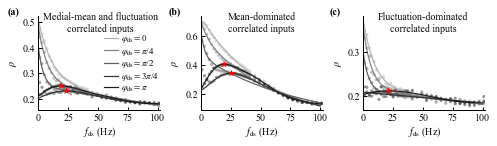

In [14]:
plt.rcParams.update({
    'font.size': 10,  
    'font.family': 'times new roman',
    'mathtext.fontset': 'stix',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic'
})
linewidth = 1
plt.rcParams['xtick.direction'] = 'in'   
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = linewidth
plt.rcParams['ytick.major.width'] = linewidth
lw=1.2
size=10
alpha=0.5
starsize=60
fig, ax = plt.subplots(1, 3, figsize=(7, 2))
ax0, ax1, ax2 = ax[0], ax[1], ax[2]

########################################################################################################################################
# Figure 9(a)
########################################################################################################################################
list_fE  = np.hstack((np.arange(1, 41, 2), np.arange(41, 100+4, 4)))
addrList = ['data/times40_c03_mu14pA_sigma35pA_AE20_fE0-100_phi-00pi.npy', 'data/times40_c03_mu14pA_sigma35pA_AE20_fE0-100_phi-25pi.npy',
            'data/times40_c03_mu14pA_sigma35pA_AE20_fE0-100_phi-50pi.npy', 'data/times40_c03_mu14pA_sigma35pA_AE20_fE0-100_phi-75pi.npy',
            'data/times40_c03_mu14pA_sigma35pA_AE20_fE0-100_phi-100pi.npy']
labelList = [r'$\mathit{\varphi}_{\mathrm{ds}}=$0', r'$\mathit{\varphi}_{\mathrm{ds}}=\pi$/4', r'$\mathit{\varphi}_{\mathrm{ds}}=\pi$/2', 
             r'$\mathit{\varphi}_{\mathrm{ds}}=$3$\pi$/4',  r'$\mathit{\varphi}_{\mathrm{ds}}=\pi$']
# colors=['#0072BD', '#D95319', '#77AC30',  '#A2142F', '#7E2F8E']
colors=['#B2B2B2', '#808080', '#5F5F5F', '#333333', '#1C1C1C']
for i in range(5):
    res      = np.load(addrList[i])
    res      = res.transpose(0, 3, 2, 1) # shape=(results, times, frequency, phi)
    data_rou = res.mean(axis=0)[2]
    if i<=2:
        ax0.scatter(list_fE[:], data_rou[0][:], s=size, fc=colors[i], ec=None, alpha=alpha, zorder=-1)
        x, y = list_fE[:], data_rou[0][:]
        init_values = [0.01 for i in range(4)]
        best_vals, covar = curve_fit(exp2fit, x, y, p0=init_values, maxfev = 1000000)
        xfit        = np.arange(0, 100, 0.1)
        yfit        = exp2fit(xfit, *best_vals)
        ax0.plot(xfit, yfit, color=colors[i], lw=lw, zorder=i, label=labelList[i])
    elif i==3:
        ax0.scatter(list_fE[:], data_rou[0][:], s=size, fc=colors[i], ec=None, alpha=alpha, zorder=-1)
        xfit        = np.arange(0, 100, 0.1)
        yfit        = gauss2fit(xfit, *[0.1049, 11.88, 44.04, 0.1785, 91.5, 123.8])
        ax0.plot(xfit, yfit, color=colors[i], lw=lw, zorder=i, label=labelList[i])
        ax0.scatter(xfit[np.argmax(yfit)], yfit.max(), marker='*', s=starsize, facecolor='r', ec=None, zorder=10)
    else:
        ax0.scatter(list_fE[:], data_rou[0][:], s=size, fc=colors[i], ec=None, alpha=alpha, zorder=-1)
        xfit        = np.arange(0, 100, 0.1)
        yfit        = gauss3fit(xfit, *[0.1205, 10.02, 28.94, 0.06303, 47.93, 34.96, 0.2, 175.6, 200.3])
        ax0.plot(xfit, yfit, color=colors[i], lw=lw, zorder=i, label=labelList[i])    
        ax0.scatter(xfit[np.argmax(yfit)], yfit.max(), marker='*', s=starsize, facecolor='r', ec=None, zorder=10)
ax0.legend(loc='center right', fontsize=9, frameon=False, labelspacing=0.08, handletextpad=0.4, borderpad=0.1, handlelength=1.5, borderaxespad=0)
########################################################################################################################################
# Figure 9(b): mean-dominated input
########################################################################################################################################
list_fE = np.hstack((np.arange(1, 41, 2), np.arange(41, 100+4, 4)))
res     = np.load('data/times30_c03_mu20pA_sigma15pA_AE20_fE0-100_phi0-pi.npy')
res     = res.mean(axis=0).transpose(2, 0, 1)
data_rou = res[2]
for i in range(5):
    if i<=2:
        ax1.scatter(list_fE[:], data_rou[:, i], s=size, fc=colors[i], ec=None, alpha=alpha, zorder=-1)
        x, y = list_fE[:], data_rou[:, i]
        init_values = [0.01 for i in range(4)]
        best_vals, covar = curve_fit(exp2fit, x, y, p0=init_values, maxfev = 1000000)
        xfit        = np.arange(0, 100, 0.1)
        yfit        = exp2fit(xfit, *best_vals)
        ax1.plot(xfit, yfit, color=colors[i], lw=lw, zorder=i, label=labelList[i])
    elif i==3:
        ax1.scatter(list_fE[:], data_rou[:, i], s=size, fc=colors[i], ec=None, alpha=alpha, zorder=-1)
        x, y = list_fE[:], data_rou[:, i]
        xfit        = np.arange(0, 100, 0.1)
        yfit        = gauss2fit(xfit, *[-0.513, -14.05, 27.31, 5.956e12, -3639, 665.5])
        ax1.plot(xfit, yfit, color=colors[i], lw=lw, zorder=i, label=labelList[i])
        ax1.scatter(xfit[np.argmax(yfit)], yfit.max(), marker='*', s=starsize, facecolor='r', ec=None, zorder=10)
    else:
        ax1.scatter(list_fE[:], data_rou[:, i], s=size, fc=colors[i], ec=None, alpha=alpha, zorder=-1)
        xfit        = np.arange(0, 100, 0.1)
        yfit        = gauss4fit(xfit, *[0.2554, 31.3, 32.31, 0, 28.27, 6.776e-3, 0.1316, 85.57, 79.28, 0.1442, 11.4, 16.88])
        ax1.plot(xfit, yfit, color=colors[i], lw=lw, zorder=i, label=labelList[i])    
        ax1.scatter(xfit[np.argmax(yfit)], yfit.max(), marker='*', s=starsize, facecolor='r', ec=None, zorder=10)


########################################################################################################################################
# Figure 9(c): fluctuation-dominated input
########################################################################################################################################
list_fE = np.hstack((np.arange(1, 41, 2), np.arange(41, 100+4, 4)))
res     = np.load('data/times30_c03_mu8pA_sigma55pA_AE20_fE0-100_phi0-pi.npy')
res     = res.mean(axis=0).transpose(2, 0, 1)
data_rou = res[2]

for i in range(5):
    if i<=1:
        ax2.scatter(list_fE[:], data_rou[:, i], s=size, fc=colors[i], ec=None, alpha=alpha, zorder=-1)
        x, y = list_fE[:], data_rou[:, i]
        init_values = [0.01 for i in range(4)]
        best_vals, covar = curve_fit(exp2fit, x, y, p0=init_values, maxfev = 1000000)
        xfit        = np.arange(0, 100, 0.1)
        yfit        = exp2fit(xfit, *best_vals)
        ax2.plot(xfit, yfit, color=colors[i], lw=lw, zorder=i, label=labelList[i])
    elif i==2:
        ax2.scatter(list_fE[:], data_rou[:, i], s=size, fc=colors[i], ec=None, alpha=alpha, zorder=-1)
        xfit        = np.arange(0, 100, 0.1)
        yfit        = exp2fit(xfit, *[0.08479, -0.2163, 0.2107, -0.001541])
        ax2.plot(xfit, yfit, color=colors[i], lw=lw, zorder=i, label=labelList[i])
    elif i==3:
        ax2.scatter(list_fE[:], data_rou[:, i], s=size, fc=colors[i], ec=None, alpha=alpha, zorder=-1)
        xfit        = np.arange(0, 100, 0.1)
        yfit        = poly1fit(xfit, *[-0.0002418, 0.2074])
        ax2.plot(xfit, yfit, color=colors[i], lw=lw, zorder=i, label=labelList[i])
    else:
        ax2.scatter(list_fE[:], data_rou[:, i], s=size, fc=colors[i], ec=None, alpha=alpha, zorder=-1)
        xfit        = np.arange(0, 93, 0.1)
        yfit        = poly3fit(xfit, *[1.428e-7, -2.443e-5, 8.407e-4, 0.2024])
        ax2.plot(xfit, yfit, color=colors[i], lw=lw, zorder=i, label=labelList[i])    
        ax2.scatter(xfit[np.argmax(yfit)], yfit.max(), marker='*', s=starsize, facecolor='r', ec=None, zorder=10)


for item in ax:
    item.set_xlim(0, 102)
    item.set_xticks(np.arange(0, 102, 25))
    item.set_xlabel(r'$\mathit{f}_{\mathrm{ds}}$ (Hz)', fontsize=10, labelpad=2)
    item.set_ylabel(r'$\rho$', fontsize=10, labelpad=4)
    item.spines['top'].set_color('none')
    item.spines['right'].set_color('none')
    item.spines['bottom'].set_linewidth(linewidth)
    item.spines['left'].set_linewidth(linewidth)
    item.tick_params(pad=3)


plt.tight_layout(w_pad=0, h_pad=0)
fig.text(0.02, 0.94, '(a)', fontsize=10, fontweight='bold')
fig.text(0.34, 0.94, '(b)', fontsize=10, fontweight='bold')
fig.text(0.66, 0.94, '(c)', fontsize=10, fontweight='bold')
fig.text(0.205, 0.82, 'Medial-mean and fluctuation\ncorrelated inputs', fontsize=10, horizontalalignment='center')
fig.text(0.525, 0.82, 'Mean-dominated\ncorrelated inputs', fontsize=10, horizontalalignment='center')
fig.text(0.845, 0.82, 'Fluctuation-dominated\ncorrelated inputs', fontsize=10, horizontalalignment='center')

# plt.savefig(r'C:\Users\Snowp\Desktop\figures\figure8.tif',format='tif',transparent=True,dpi=400,bbox_inches='tight')
plt.savefig(r'C:\Users\Snowp\Desktop\figures\figure8.png',format='png',transparent=True,dpi=400,bbox_inches='tight')

# Figure 9: 真是神经元复现上述结果

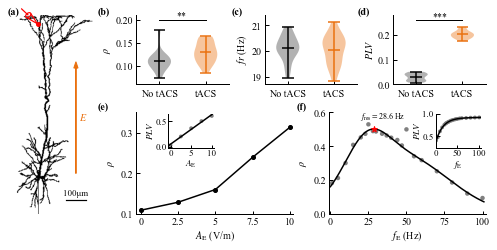

In [15]:
plt.rcParams.update({
    'font.size': 10,  
    'font.family': 'times new roman',
    'mathtext.fontset': 'stix',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic'
})
linewidth = 1
plt.rcParams['xtick.direction'] = 'in'   
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = linewidth
plt.rcParams['ytick.major.width'] = linewidth
labelpad = 1

fig = plt.figure(figsize=(7, 3.5))
shape0, shape1 = 7, 8
ax0 = plt.subplot2grid(shape=(shape0, shape1), loc=(0,0), rowspan=7, colspan=2)
ax1 = plt.subplot2grid(shape=(shape0, shape1), loc=(0,2), rowspan=3, colspan=2)
ax2 = plt.subplot2grid(shape=(shape0, shape1), loc=(0,4), rowspan=3, colspan=2)
ax3 = plt.subplot2grid(shape=(shape0, shape1), loc=(0,6), rowspan=3, colspan=2)
ax4 = plt.subplot2grid(shape=(shape0, shape1), loc=(3,2), rowspan=4, colspan=3)
ax5 = plt.subplot2grid(shape=(shape0, shape1), loc=(3,5), rowspan=4, colspan=3)


'''Figure 9(a): Neuron model'''
photo =Image.open('data/LarkumModel.png')
ax0.imshow(photo, origin='upper')
ax0.set_xlim(ax0.get_xlim()[0]-0, ax0.get_xlim()[1]+0)
ax0.set_ylim(ax0.get_ylim()[0]+0, ax0.get_ylim()[1]-0)
# ax0.scatter(44, 320, color='k', s=15) # soma
ax0.scatter(41, 16, color='r', s=15)
ax0.plot([95, 95+75/2], [350, 350], color='k', lw=1.2)
ax0.text(89.5, 343, r'100μm', fontsize=9)
ax0.arrow(95+75/4, 300, 0, -200, width=0.9, color='#EA700E', head_width=8)
ax0.text(95+75/4+5, 200, r'$\mathit{E}$', fontsize=10, color='#EA700E', fontweight='bold')
ax0.axis('off')

'''Figure 9(b-d): 交流电场能够改变相关性、放电率、PLV'''
list_AE = [0, 2.5, 5, 7.5, 10]
addr = r'C:\Users\Snowp\PycharmProjects\pythonProject\TacsEffectCorrelation\2CModel_Ladenbauer(2019)\larkum\data'
addr = os.path.join(addr, 'times20_c03_mu300_sigma200_AE0-10_fE10_apic63.npy')
res  = np.load(addr).squeeze()
data_fr  = res.transpose(2, 0, 1)[1]
data_rou = res.transpose(2, 0, 1)[2]
data_plv = res.transpose(2, 0, 1)[3]

idx = 1
positions = np.array([0, 1])
pc1 = ax1.violinplot(data_rou[:, [0, idx]], positions=positions, showmeans=True)
ax1.set_xticks(positions, labels=['No tACS', 'tACS'], fontsize=10)
ax1.set_yticks(np.arange(0.1, 0.21, 0.05))
ax1.set_ylim(0.06, 0.21)

pc2 = ax2.violinplot(data_fr[:, [0, idx]], positions=positions, showmeans=True)
ax2.set_xticks(positions, labels=['No tACS', 'tACS'], fontsize=10)
ax2.set_yticks(np.arange(19, 21.1, 1))
ax2.set_ylim(19-0.3, 21.4)

pc3 = ax3.violinplot(data_plv[:, [0, idx]], positions=positions, showmeans=True)
ax3.set_xticks(positions, labels=['No tACS', 'tACS'], fontsize=10)
ax3.set_yticks(np.arange(0, 0.21, 0.1))
ax3.set_ylim(0, 0.28)

ax1.set_ylabel(r'$\rho$', fontsize=10, labelpad=3)
ax2.set_ylabel('$fr$ (Hz)', fontsize=10, labelpad=3)
ax3.set_ylabel(r'$\mathit{PLV}$', fontsize=10, labelpad=3)
for item in [ax1, ax2, ax3]:
    item.tick_params('y', pad=3)
    item.tick_params('x', pad=4)
    item.spines['top'].set_color('none')
    item.spines['right'].set_color('none')
    item.spines['bottom'].set_linewidth(linewidth)
    item.spines['left'].set_linewidth(linewidth)
    item.set_xlim(0-0.5, 1+0.5)
colors = ['grey', '#EA700E']
for pci in [pc1, pc2, pc3]:
    pci['cmeans'].set_color(['k', '#EA700E'])
    pci['cmaxes'].set_color(['k', '#EA700E'])
    pci['cmins'].set_color(['k', '#EA700E'])
    pci['cbars'].set_color(['k', '#EA700E'])

    pci['bodies'][0].set_facecolor('grey')
    pci['bodies'][0].set_alpha(0.6)
    pci['bodies'][1].set_facecolor('#EA700E')
    pci['bodies'][1].set_alpha(0.4)
ax1.plot([0, 1], [0.2, 0.2], lw=1, color='k')
ax1.text(0.36, .2, '**', fontsize=10)
ax3.plot([0, 1], [0.26, 0.26], lw=1, color='k')
ax3.text(0.36, .26, '***', fontsize=10)



'''Figure 9(e): 电场强度如何影响相关性'''
list_AE = [0, 2.5, 5, 7.5, 10]
addr = r'C:\Users\Snowp\PycharmProjects\pythonProject\TacsEffectCorrelation\2CModel_Ladenbauer(2019)\larkum\data'
addr = os.path.join(addr, 'times20_c03_mu300_sigma200_AE0-10_fE10_apic63.npy')
res  = np.load(addr).squeeze()
data_fr  = res.transpose(2, 0, 1)[1].mean(axis=0)
data_rou = res.transpose(2, 0, 1)[2].mean(axis=0)
data_plv = res.transpose(2, 0, 1)[3].mean(axis=0)
ax4.plot(list_AE, data_rou, marker='o', ms=4, color='k', lw=1.5)
ax4.set_xticks([0, 2.5, 5, 7.5, 10], ['0', '2.5', '5', '7.5', '10'])
ax4.set_yticks([0.1, 0.2, 0.3])
ax4.set_xlim(-0.3, 10.2)
ax4.set_ylim(0.1, 0.35)
ax4.set_xlabel(r'$\mathit{A}_{\mathrm{E}}$ (V/m)', fontsize=10, labelpad=2)
ax4.set_ylabel(r'$\rho$', fontsize=10)

# ylist = np.linspace(0.25, 0.33, 4)
# ax4.plot([0, 2.5], [ylist[0], ylist[0]], lw=1, color='k')
# ax4.text(0.92, ylist[0], '**', fontsize=10)
# ax4.plot([0, 5], [ylist[1], ylist[1]], lw=1, color='k')
# ax4.text(2, ylist[1], '***', fontsize=10)
# ax4.plot([0, 7.5], [ylist[2], ylist[2]], lw=1, color='k')
# ax4.text(3.25, ylist[2], '***', fontsize=10)
# ax4.plot([0, 10], [ylist[3], ylist[3]], lw=1, color='k')
# ax4.text(4.5, ylist[3], '***', fontsize=10)

'''Figure 9(f): 电场频率如何影响相关性'''
list_fE = [1, 5, 10, 15, 20, 25] + [30, 40, 50, 60] + [70, 80, 90, 100] + [23, 28, 34, 37, 44, 47, 55]
addr0 = r'C:\Users\Snowp\PycharmProjects\pythonProject\TacsEffectCorrelation\2CModel_Ladenbauer(2019)\larkum\data'
addr  = os.path.join(addr0, 'times10_c03_mu300_sigma200_AE10_fE1-5-10-15-20-25_apic63.npy')
res1  = np.load(addr).squeeze()
addr  = os.path.join(addr0, 'times10_c03_mu300_sigma200_AE10_fE30-40-50-60_apic63.npy')
res2  = np.load(addr).squeeze()
addr  = os.path.join(addr0, 'times10_c03_mu300_sigma200_AE10_fE70-80-90-100_apic63.npy')
res3  = np.load(addr).squeeze()
addr  = os.path.join(addr0, 'times10_c03_mu300_sigma200_AE10_fE23-28-34-37-44-47-55_apic63.npy')
res4  = np.load(addr).squeeze()
res = np.concatenate((res1, res2, res3, res4), axis=1)
data_rou = res.transpose(2, 0, 1)[2].mean(axis=0)
data_plv = res.transpose(2, 0, 1)[3].mean(axis=0)
xfit = np.arange(0, 101, 0.1)
matlab_paras = [0.2335, 23.51, 19.86, 0.3403, 47.11, 43.34]
yfit = gauss2fit(xfit, *matlab_paras)
ax5.scatter(list_fE, data_rou, s=20, ec=None, fc='grey', alpha=1)
ax5.plot(xfit, yfit, color='k', lw=1.5)
ax5.scatter(xfit[np.argmax(yfit)], yfit.max(), marker='*', s=35, facecolor='r', zorder=5)
ax5.text(19.5, 0.56, r'$f_\mathrm{res}=$%.1f Hz' % xfit[np.argmax(yfit)], fontsize=8)
ax5.set_xticks(np.arange(0, 101, 25))
ax5.set_xlim(-1, 102)
ax5.set_yticks(np.arange(0, 0.61, 0.2))
ax5.set_xlabel(r'$\mathit{f}_{\mathrm{E}}$ (Hz)', fontsize=10, labelpad=2)
ax5.set_ylabel(r'$\rho$', fontsize=10)


for item in [ax4, ax5]:
    item.tick_params(pad=3)
    item.spines['top'].set_color('none')
    item.spines['right'].set_color('none')
    item.spines['bottom'].set_linewidth(linewidth)
    item.spines['left'].set_linewidth(linewidth)
plt.tight_layout(w_pad=0.3, h_pad=1)

fig.text(0.02, 0.95, '(a)', fontsize=10, fontweight='bold')
fig.text(0.20, 0.95, '(b)', fontsize=10, fontweight='bold')
fig.text(0.465, 0.95, '(c)', fontsize=10, fontweight='bold')
fig.text(0.715, 0.95, '(d)', fontsize=10, fontweight='bold')
fig.text(0.20, 0.57, '(e)', fontsize=10, fontweight='bold')
fig.text(0.595, 0.57, '(f)', fontsize=10, fontweight='bold')
###############################################################
'''Figure 9(a)-supplyment'''
ax01 = fig.add_axes((0.05-0.003, 0.905+0.007, 0.033, 0.062))
ax01.set_xticks([]); ax01.set_yticks([])
ax01.set_xlim(-5, 100)
ax01.set_ylim(0, 105)
lw=1.2
centerx, centery = 40+2, 60-2
circlePatch = mpatches.Ellipse((centerx, centery), 40, 25, ec='r', lw=lw, fill=False, angle=45)
ax01.add_artist(circlePatch)
ax01.plot([35, 100], [40, 0], color='r', lw=lw)
ax01.plot([60, 100], [65, 0], color='r', lw=lw)
ax01.plot([0, 40], [100, 60], color='r', lw=lw)
ax01.axis('off')
###############################################################
ax41 = fig.add_axes([0.34, 0.42, 0.09, 0.135])
list_AE = [0, 2.5, 5, 7.5, 10]
addr = r'C:\Users\Snowp\PycharmProjects\pythonProject\TacsEffectCorrelation\2CModel_Ladenbauer(2019)\larkum\data'
addr = os.path.join(addr, 'times20_c03_mu300_sigma200_AE0-10_fE10_apic63.npy')
res  = np.load(addr).squeeze()
data_plv = res.transpose(2, 0, 1)[3].mean(axis=0)
x, y = list_AE, data_plv
init_values = [0.1 for i in range(2)]
best_vals, covar = curve_fit(poly1fit, x, y, p0=init_values, maxfev = 1000000)
xfit = np.arange(-0.5, 10.2, 0.1)
yfit = poly1fit(xfit, *best_vals)
ax41.scatter(list_AE, data_plv, s=15, ec=None, fc='grey', alpha=1)
ax41.plot(xfit, yfit, color='k', lw=1.5)
ax41.tick_params(pad=2, labelsize=9)
ax41.spines['top'].set_color('none')
ax41.spines['right'].set_color('none')
ax41.spines['bottom'].set_linewidth(linewidth)
ax41.spines['left'].set_linewidth(linewidth)
ax41.set_ylim(-0.02, 0.65)
ax41.set_xlim(-0.5, 10.5)
ax41.set_xticks([0, 5, 10])
ax41.set_xlabel(r'$\mathit{A}_{\mathrm{E}}$', fontsize=9, labelpad=1)
ax41.set_ylabel(r'$\mathit{PLV}$', fontsize=9, labelpad=0)
###############################################################
ax51 = fig.add_axes([0.87, 0.42, 0.09, 0.135])
list_fE = [1, 5, 10, 15, 20, 25] + [30, 40, 50, 60] + [70, 80, 90, 100] + [23, 28, 34, 37, 44, 47, 55]
addr0 = r'C:\Users\Snowp\PycharmProjects\pythonProject\TacsEffectCorrelation\2CModel_Ladenbauer(2019)\larkum\data'
addr  = os.path.join(addr0, 'times10_c03_mu300_sigma200_AE10_fE1-5-10-15-20-25_apic63.npy')
res1  = np.load(addr).squeeze()
addr  = os.path.join(addr0, 'times10_c03_mu300_sigma200_AE10_fE30-40-50-60_apic63.npy')
res2  = np.load(addr).squeeze()
addr  = os.path.join(addr0, 'times10_c03_mu300_sigma200_AE10_fE70-80-90-100_apic63.npy')
res3  = np.load(addr).squeeze()
addr  = os.path.join(addr0, 'times10_c03_mu300_sigma200_AE10_fE23-28-34-37-44-47-55_apic63.npy')
res4  = np.load(addr).squeeze()
res = np.concatenate((res1, res2, res3, res4), axis=1)
data_rou = res.transpose(2, 0, 1)[2].mean(axis=0)
data_plv = res.transpose(2, 0, 1)[3].mean(axis=0)
xfit = np.arange(0, 104, 0.5)
yfit = exp2fit(xfit, *[0.9085, 0.0001131, -0.5484, -0.06174])
ax51.scatter(list_fE, data_plv, s=15, ec=None, fc='grey', alpha=1)
ax51.plot(xfit, yfit, color='k', lw=1.5)
ax51.tick_params(pad=2, labelsize=9)
ax51.spines['top'].set_color('none')
ax51.spines['right'].set_color('none')
ax51.spines['bottom'].set_linewidth(linewidth)
ax51.spines['left'].set_linewidth(linewidth)
ax51.set_ylim(0.25, 1)
ax51.set_xlim(0, 104)
ax51.set_xticks([0, 50, 100])
ax51.set_xlabel(r'$\mathit{f}_{\mathrm{E}}$', fontsize=9, labelpad=1)
ax51.set_ylabel(r'$\mathit{PLV}$', fontsize=9, labelpad=0)


# plt.savefig(r'C:\Users\Snowp\Desktop\figures\figure9.tif',format='tif',transparent=True,dpi=400,bbox_inches='tight')
plt.savefig(r'C:\Users\Snowp\Desktop\figures\figure9.png',format='png',transparent=True,dpi=400,bbox_inches='tight')

# Figure 10: 用上述理论解释共振

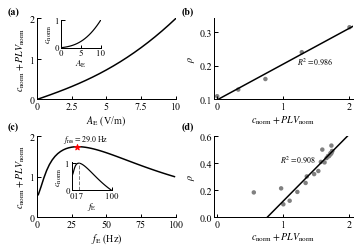

In [16]:
plt.rcParams.update({
    'font.size': 10,  
    'font.family': 'times new roman',
    'mathtext.fontset': 'stix',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic'
})
linewidth = 1
plt.rcParams['xtick.direction'] = 'in'   
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = linewidth
plt.rcParams['ytick.major.width'] = linewidth

fig, ax = plt.subplots(2, 2, figsize=(5, 3.5))
ax0, ax1, ax2, ax3 = ax[0, 0], ax[0, 1], ax[1, 0], ax[1, 1]
#############################################################
#############################################################
list_AE = np.arange(0, 10.1, 0.5)
list_fE = np.arange(1, 100, 2)
addr = r'C:\Users\Snowp\PycharmProjects\pythonProject\TacsEffectCorrelation\2CModel_Ladenbauer(2019)\larkum\data'
addr = os.path.join(addr, 'somaAp_mu300_sigma200_AE0-10_fE10_dend63.npy')
list_Ap = np.load(addr).squeeze()*10*1e-3
data_c = poly4fit(list_Ap, *[-1034, 166.4, 1.697, 0.05213, 0.3001])
data_norm_c = (data_c-data_c.min())/(data_c.max()-data_c.min())

list_AE = [0, 2.5, 5, 7.5, 10]
addr = r'C:\Users\Snowp\PycharmProjects\pythonProject\TacsEffectCorrelation\2CModel_Ladenbauer(2019)\larkum\data'
addr = os.path.join(addr, 'times20_c03_mu300_sigma200_AE0-10_fE10_apic63.npy')
res  = np.load(addr).squeeze()
data_plv = res.transpose(2, 0, 1)[3].mean(axis=0)
x, y = list_AE, data_plv
init_values = [0.1 for i in range(2)]
best_vals, covar = curve_fit(poly1fit, x, y, p0=init_values, maxfev = 1000000)
list_AE = np.arange(0, 10.1, 0.5)
data_plv = poly1fit(list_AE, *best_vals)
data_norm_plv = (data_plv-data_plv.min())/(data_plv.max()-data_plv.min())
ax0.plot(list_AE, data_norm_c+data_norm_plv, lw=1.5, color='k')
#############################################################
#############################################################
list_AE = [0, 2.5, 5, 7.5, 10]
addr = r'C:\Users\Snowp\PycharmProjects\pythonProject\TacsEffectCorrelation\2CModel_Ladenbauer(2019)\larkum\data'
addr = os.path.join(addr, 'times20_c03_mu300_sigma200_AE0-10_fE10_apic63.npy')
res  = np.load(addr).squeeze()
data_plv = res.transpose(2, 0, 1)[3].mean(axis=0)
data_rou = res.transpose(2, 0, 1)[2].mean(axis=0)
cnorm = np.interp(list_AE, np.arange(0, 10.1, 0.5), data_norm_c)
plvnorm = np.interp(list_AE, np.arange(0, 10.1, 0.5), data_norm_plv)
xfit = np.arange(-0.1, 2.1, 0.02)
yfit = poly1fit(xfit, *[0.1061, 0.09884])
ax1.scatter(cnorm+plvnorm, data_rou, marker='o', s=20, color='grey', ec=None, alpha=1, zorder=-1)
ax1.plot(xfit, yfit, lw=1.5, color='k')
ax1.text(1.2, 0.2, r'$R^2=$0.986', fontsize=8, color='k')
#############################################################
#############################################################
list_AE = np.arange(0, 10.1, 0.5)
list_fE = np.arange(1, 100, 2)
addr = r'C:\Users\Snowp\PycharmProjects\pythonProject\TacsEffectCorrelation\2CModel_Ladenbauer(2019)\larkum\data'
addr = os.path.join(addr, 'somaAp_mu300_sigma200_AE10_fE1-100_dend63.npy')
list_Ap = np.load(addr).squeeze()*10*1e-3
data_c = poly4fit(list_Ap, *[-1034, 166.4, 1.697, 0.05213, 0.3001])
data_norm_c = (data_c-data_c.min())/(data_c.max()-data_c.min())
data_plv = exp2fit(list_fE, *[0.9085, 0.0001131, -0.5484, -0.06174])
data_norm_plv = (data_plv-data_plv.min())/(data_plv.max()-data_plv.min())
# ax2.plot(list_fE, data_norm_c)
# ax2.plot(list_fE, data_norm_plv)
ax2.plot(list_fE, data_norm_c + data_norm_plv, color='k', lw=1.5)
xfit = np.arange(1, 100, 0.1)
yfit = np.interp(xfit, list_fE, data_norm_c + data_norm_plv)
ax2.scatter(xfit[np.argmax(yfit)], yfit.max(), marker='*', s=35, facecolor='r', zorder=5)
ax2.text(19, 1.88, r'$f_\mathrm{res}=$%.1f Hz' % xfit[np.argmax(yfit)], fontsize=8)


#############################################################
#############################################################
list_fE = [1, 5, 10, 15, 20, 25] + [30, 40, 50, 60] + [70, 80, 90, 100] + [23, 28, 34, 37, 44, 47, 55]
addr0 = r'C:\Users\Snowp\PycharmProjects\pythonProject\TacsEffectCorrelation\2CModel_Ladenbauer(2019)\larkum\data'
addr  = os.path.join(addr0, 'times10_c03_mu300_sigma200_AE10_fE1-5-10-15-20-25_apic63.npy')
res1  = np.load(addr).squeeze()
addr  = os.path.join(addr0, 'times10_c03_mu300_sigma200_AE10_fE30-40-50-60_apic63.npy')
res2  = np.load(addr).squeeze()
addr  = os.path.join(addr0, 'times10_c03_mu300_sigma200_AE10_fE70-80-90-100_apic63.npy')
res3  = np.load(addr).squeeze()
addr  = os.path.join(addr0, 'times10_c03_mu300_sigma200_AE10_fE23-28-34-37-44-47-55_apic63.npy')
res4  = np.load(addr).squeeze()
res = np.concatenate((res1, res2, res3, res4), axis=1)
data_rou = res.transpose(2, 0, 1)[2].mean(axis=0)
data_plv = res.transpose(2, 0, 1)[3].mean(axis=0)
cnorm = np.interp(list_fE, np.arange(1, 100, 2), data_norm_c)
plvnorm = np.interp(list_fE, np.arange(1, 100, 2), data_norm_plv)
xfit = np.arange(-0.1, 2.1, 0.02)
yfit = poly1fit(xfit, *[0.4953, -0.3754])
ax3.scatter(cnorm+plvnorm, data_rou, marker='o', s=20, color='grey', ec=None, alpha=1, zorder=-1)
ax3.plot(xfit, yfit, lw=1.5, color='k')
ax3.text(0.95, 0.4, r'$R^2=$0.908', fontsize=8, color='k')
#############################################################
#############################################################
ax0.set_xlim(0, 10)
ax0.set_ylim(0, 2)
ax1.set_xlim(-0.05, 2.05)
ax1.set_ylim(0.1, 0.34)
ax2.set_xlim(0, 100)
ax2.set_ylim(0, 2)
ax3.set_xlim(-0.05, 2.05)
ax3.set_ylim(0., 0.6)
ax0.set_yticks([0, 1, 2])
ax2.set_yticks([0, 1, 2])
ax0.set_xticks(np.arange(0, 10.1, 2.5), labels=['0', '2.5', '5', '7.5', '10'])


ax0.set_ylabel(r'$\mathit{c}_{\mathrm{norm}}+\mathit{PLV}_{\mathrm{norm}}$', fontsize=10, labelpad=3)
ax1.set_ylabel(r'$\rho$', fontsize=10, labelpad=2)
ax2.set_ylabel(r'$\mathit{c}_{\mathrm{norm}}+\mathit{PLV}_{\mathrm{norm}}$', fontsize=10, labelpad=3)
ax3.set_ylabel(r'$\rho$', fontsize=10, labelpad=2)

ax0.set_xlabel(r'$\mathit{A}_{\mathrm{E}}$ (V/m)', fontsize=10, labelpad=2)
ax1.set_xlabel(r'$\mathit{c}_{\mathrm{norm}}+\mathit{PLV}_{\mathrm{norm}}$', fontsize=10, labelpad=2)
ax2.set_xlabel(r'$\mathit{f}_{\mathrm{E}}$ (Hz)', fontsize=10, labelpad=2)
ax3.set_xlabel(r'$\mathit{c}_{\mathrm{norm}}+\mathit{PLV}_{\mathrm{norm}}$', fontsize=10, labelpad=2)

for item in [ax0, ax1, ax2, ax3]:
    item.tick_params(pad=2)
    item.spines['top'].set_color('none')
    item.spines['right'].set_color('none')
    item.spines['bottom'].set_linewidth(linewidth)
    item.spines['left'].set_linewidth(linewidth)

plt.tight_layout(w_pad=0.3, h_pad=0.5)
fig.text(0.01, 0.96, '(a)', fontsize=10, fontweight='bold')
fig.text(0.495, 0.96, '(b)', fontsize=10, fontweight='bold')
fig.text(0.01, 0.5, '(c)', fontsize=10, fontweight='bold')
fig.text(0.495, 0.5, '(d)', fontsize=10, fontweight='bold')

##############################################################################
##############################################################################
ax01 = fig.add_axes([0.16, 0.825, 0.11, 0.11])
list_AE = np.arange(0, 10.1, 0.5)
addr = r'C:\Users\Snowp\PycharmProjects\pythonProject\TacsEffectCorrelation\2CModel_Ladenbauer(2019)\larkum\data'
addr = os.path.join(addr, 'somaAp_mu300_sigma200_AE0-10_fE10_dend63.npy')
list_Ap = np.load(addr).squeeze()*10*1e-3
data_c = poly4fit(list_Ap, *[-1034, 166.4, 1.697, 0.05213, 0.3001])
data_norm_c = (data_c-data_c.min())/(data_c.max()-data_c.min())
ax01.plot(list_AE, data_norm_c, color='k', lw=1.2)
ax01.tick_params(pad=2, labelsize=9)
ax01.spines['top'].set_color('none')
ax01.spines['right'].set_color('none')
ax01.spines['bottom'].set_linewidth(linewidth)
ax01.spines['left'].set_linewidth(linewidth)
ax01.set_ylim(0, 1)
ax01.set_xlim(0, 10)
ax01.set_xticks([0, 5, 10])
ax01.set_xlabel(r'$\mathit{A}_{\mathrm{E}}$', fontsize=9, labelpad=0)
ax01.set_ylabel(r'$\mathit{c}_{\mathrm{norm}}$', fontsize=9, labelpad=1)
###########################################
ax21 = fig.add_axes([0.19, 0.26, 0.11, 0.11])
list_fE = np.arange(1, 100, 2)
addr = r'C:\Users\Snowp\PycharmProjects\pythonProject\TacsEffectCorrelation\2CModel_Ladenbauer(2019)\larkum\data'
addr = os.path.join(addr, 'somaAp_mu300_sigma200_AE10_fE1-100_dend63.npy')
list_Ap = np.load(addr).squeeze()*10*1e-3
data_c = poly4fit(list_Ap, *[-1034, 166.4, 1.697, 0.05213, 0.3001])
data_norm_c = (data_c-data_c.min())/(data_c.max()-data_c.min())
ax21.plot(list_fE, data_norm_c, color='k', lw=1.2)
xfit = np.arange(0, 100, 0.1)
yfit = np.interp(xfit, list_fE, data_norm_c)
ax21.plot([xfit[np.argmax(yfit)]]*2, [0, yfit.max()], ls='--', lw=1, color='grey')
ax21.tick_params(pad=2, labelsize=9)
ax21.spines['top'].set_color('none')
ax21.spines['right'].set_color('none')
ax21.spines['bottom'].set_linewidth(linewidth)
ax21.spines['left'].set_linewidth(linewidth)
ax21.set_ylim(0, 1.03)
ax21.set_xlim(0, 100)
ax21.set_xticks([0, xfit[np.argmax(yfit)], 100])
ax21.set_xlabel(r'$\mathit{f}_{\mathrm{E}}$', fontsize=9, labelpad=0)
ax21.set_ylabel(r'$\mathit{c}_{\mathrm{norm}}$', fontsize=9, labelpad=1)

# plt.savefig(r'C:\Users\Snowp\Desktop\figures\figure10.tif',format='tif',transparent=True,dpi=400,bbox_inches='tight')
plt.savefig(r'C:\Users\Snowp\Desktop\figures\figure10.png',format='png',transparent=True,dpi=400,bbox_inches='tight')

# Figure S1: 输入扰动对相关性的影响

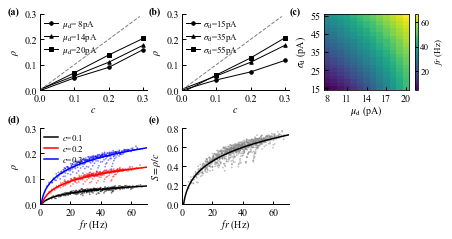

In [3]:
plt.rcParams.update({
    'font.size': 10,  
    'font.family': 'times new roman',
    'mathtext.fontset': 'stix',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic'
})
linewidth = 1
plt.rcParams['xtick.direction'] = 'in'   
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = linewidth
plt.rcParams['ytick.major.width'] = linewidth
labelpad = 1
fig, ax = plt.subplots(2, 3, figsize=(7, 3.5))

list_c     = [0.0, 0.1, 0.2, 0.3]
list_mu    = np.arange(8, 20+0.1, 1)
list_sigma = np.array(sorted(np.arange(15, 55+1, 2).tolist() + [30]))
res        = np.load('data/times20_c00-03_mu8-20pA_sigma15-55pA.npy')
data_rou   = np.mean(res, axis=0).transpose(3, 1, 2, 0)[2] # shape=(mu, sigma, cin)
'''Figure 3(a): rou-c with different mu'''
mu_index = [0, 6, -1]
marker = ['o', '^', 's']
for i in range(3):
    ax[0, 0].plot(list_c, data_rou[mu_index[i]][11], color='k', marker=marker[i], ms=3.5, lw=1, label=r'$\mu_{\mathrm{d}}$=%2dpA' % list_mu[mu_index[i]])
ax[0, 0].legend(fontsize=9, frameon=False, labelspacing=0.1, handletextpad=0.4, borderpad=0.5, handlelength=1.5, borderaxespad=0)
ax[0, 0].plot([0, 0.29], [0, 0.29], ls='--', color='grey', lw=1)
ax[0, 0].set_xlabel(r'$c$', fontsize=10, labelpad=labelpad)
ax[0, 0].set_ylabel(r'$\rho$', fontsize=10, labelpad=labelpad+2)
ax[0, 0].set_xlim(0, 0.31)
ax[0, 0].set_ylim(0, 0.3)
ax[0, 0].set_xticks([0, 0.1, 0.2, 0.3])
ax[0, 0].set_yticks([0, 0.1, 0.2, 0.3])
ax[0, 0].tick_params(pad=3)
ax[0, 0].spines['top'].set_color('none')
ax[0, 0].spines['right'].set_color('none')
ax[0, 0].spines['bottom'].set_linewidth(linewidth)
ax[0, 0].spines['left'].set_linewidth(linewidth)

'''Figure 3(b): rou-c with different sigma'''
sigma_index = [0, 11, -1]
marker = ['o', '^', 's']
for i in range(3):
    ax[0, 1].plot(list_c, data_rou[6][sigma_index[i]], color='k', marker=marker[i], ms=3.5, lw=1, label='$\sigma_{\mathrm{d}}$=%2dpA' % list_sigma[sigma_index[i]])
ax[0, 1].legend(fontsize=9, frameon=False, labelspacing=0.1, handletextpad=0.4, borderpad=0.5, handlelength=1.5, borderaxespad=0)
ax[0, 1].plot([0, 0.29], [0, 0.29], ls='--', color='grey', lw=1)
ax[0, 1].set_xlabel(r'$c$', fontsize=10, labelpad=labelpad)
ax[0, 1].set_ylabel(r'$\rho$', fontsize=10, labelpad=labelpad+2)
ax[0, 1].set_xticks([0, 0.1, 0.2, 0.3])
ax[0, 1].set_yticks([0, 0.1, 0.2, 0.3])
ax[0, 1].set_xlim(0, 0.31)
ax[0, 1].set_ylim(0, 0.3)
ax[0, 1].tick_params(pad=3)
ax[0, 1].spines['top'].set_color('none')
ax[0, 1].spines['right'].set_color('none')
ax[0, 1].spines['bottom'].set_linewidth(linewidth)
ax[0, 1].spines['left'].set_linewidth(linewidth)

'''Figure 3(c): 确定刺激参数范围'''
list_c     = [0.0, 0.1, 0.2, 0.3]
list_mu    = np.arange(8, 20+0.1, 1)
list_sigma = np.array(sorted(np.arange(15, 55+1, 2).tolist() + [30]))
res        = np.load('data/times20_c00-03_mu8-20pA_sigma15-55pA.npy')
data_rou   = np.mean(res, axis=0).transpose(3, 1, 2, 0)[2] # shape=(mu, sigma, cin)
'''μ-σ-fr with c=0.3'''
yfr  = np.mean(res, axis=0).transpose(3, 0, 2, 1)[1][-1] # shape=(mu, sigma)
ipm  = ax[0, 2].pcolormesh(list_mu, list_sigma, yfr, shading='auto')
cbar = plt.colorbar(ipm, ax=ax[0, 2], label=r'$fr$ (Hz)')
cbar.set_ticks([20, 40, 60], fontsize=9)
cbar.set_label(r'$fr$ (Hz)', fontsize=9, labelpad=labelpad+2)
cbar.ax.tick_params(labelsize=9, pad=2)
ax[0, 2].set_xlabel(r'$\mu_{\mathrm{d}}$ (pA)', fontsize=10, labelpad=labelpad)
ax[0, 2].set_ylabel(r'$\sigma_{\mathrm{d}}$ (pA)', fontsize=10, labelpad=labelpad+2)
ax[0, 2].set_xticks(np.arange(8, 20+1, 3))
ax[0, 2].set_yticks(np.arange(15, 55+1, 10))
ax[0, 2].tick_params(pad=3)


'''Figure 3(d): rou-fr with different c'''
list_c     = [0.0, 0.1, 0.2, 0.3]
list_mu    = np.arange(8, 20+0.1, 1)
list_sigma = np.array(sorted(np.arange(15, 55+1, 2).tolist() + [30]))
res        = np.load('data/times20_c00-03_mu8-20pA_sigma15-55pA.npy')
list_x, list_y, list_xfit, list_yfit  = [], [], [], []
for i in [1, 2, 3]:
    data_rou   = np.mean(res, axis=0).transpose(3, 0, 1, 2)[2][i] # shape=(mu, sigma), cin=0.3
    data_fr    = np.mean(res, axis=0).transpose(3, 0, 1, 2)[1][i] # shape=(mu, sigma), cin=0.3
    data_rou, data_fr = data_rou.flatten(), data_fr.flatten()
    xtemp       = sorted(enumerate(data_fr), key=itemgetter(1))
    xindex      = map(itemgetter(0), xtemp)
    multi_piker = itemgetter(*xindex)
    x           = np.array(multi_piker(data_fr))
    y           = np.array(multi_piker(data_rou))
    init_values = [0.1 for i in range(3)]
    best_vals, covar = curve_fit(powerfit, x, y, p0=init_values, maxfev = 1000000)
    xfit        = np.arange(0, 70, 0.01)
    yfit        = powerfit(xfit, *best_vals)
    list_x.append(x)
    list_y.append(y)
    list_xfit.append(xfit)
    list_yfit.append(yfit)
colors=['k', 'r', 'b']
for i in range(3):
    ax[1, 0].scatter(list_x[i], list_y[i], color=colors[i], s=3, ec=None, alpha=0.5)
    ax[1, 0].plot(list_xfit[i], list_yfit[i], color=colors[i], lw=1.5, label='$c$=%.1f' % list_c[i+1])
ax[1, 0].legend(fontsize=9, frameon=False, labelspacing=0.1, handletextpad=0.4, borderpad=0.5, handlelength=1.5, borderaxespad=0)
ax[1, 0].set_xlabel(r'$fr$ (Hz)', fontsize=10, labelpad=labelpad)
ax[1, 0].set_ylabel(r'$\rho$', fontsize=10, labelpad=labelpad+2)
ax[1, 0].set_xlim(0, 70)
ax[1, 0].set_ylim(0., 0.3)
ax[1, 0].set_yticks([0, 0.1, 0.2, 0.3])
ax[1, 0].set_xticks([0, 20, 40, 60])
ax[1, 0].tick_params(pad=3)
ax[1, 0].spines['top'].set_color('none')
ax[1, 0].spines['right'].set_color('none')
ax[1, 0].spines['bottom'].set_linewidth(linewidth)
ax[1, 0].spines['left'].set_linewidth(linewidth)


'''Figure 3(e): susceptibiliy-firing rate relationship'''
list_x, list_y = np.array([]), np.array([])
for i in [1, 2, 3]:
    data_rou   = np.mean(res, axis=0).transpose(3, 0, 1, 2)[2][i] # shape=(mu, sigma), cin=0.3
    data_fr    = np.mean(res, axis=0).transpose(3, 0, 1, 2)[1][i] # shape=(mu, sigma), cin=0.3
    data_rou   = data_rou / list_c[i]
    data_rou, data_fr = data_rou.flatten(), data_fr.flatten()
    list_x = np.hstack((list_x, data_fr))
    list_y = np.hstack((list_y, data_rou))
xtemp       = sorted(enumerate(list_x), key=itemgetter(1))
xindex      = map(itemgetter(0), xtemp)
multi_piker = itemgetter(*xindex)
x           = np.array(multi_piker(list_x))
y           = np.array(multi_piker(list_y))
init_values = [0.1 for i in range(3)]
best_vals, covar = curve_fit(powerfit, x, y, p0=init_values, maxfev = 1000000)
xfit        = np.arange(0, 70, 0.01)
yfit        = powerfit(xfit, *best_vals)
ax[1, 1].scatter(x, y, color='grey', s=3, ec=None, alpha=0.5)
ax[1, 1].plot(xfit, yfit, color='k', lw=1.5)
ax[1, 1].set_xlabel(r'$fr$ (Hz)', fontsize=10, labelpad=labelpad)
ax[1, 1].set_ylabel(r'$S=\rho/c$', fontsize=10, labelpad=labelpad+2)
ax[1, 1].set_xlim(0, 70)
ax[1, 1].set_ylim(0., 0.8)
ax[1, 1].set_yticks([0, 0.2, 0.4, 0.6, 0.8])
ax[1, 1].set_xticks([0, 20, 40, 60])
ax[1, 1].tick_params(pad=3)
ax[1, 1].spines['top'].set_color('none')
ax[1, 1].spines['right'].set_color('none')
ax[1, 1].spines['bottom'].set_linewidth(linewidth)
ax[1, 1].spines['left'].set_linewidth(linewidth)



'''Figure 3(f): None'''
ax[1, 2].axis('off')

fig.text(0.06, 0.88, '(a)', fontsize=10, fontweight='bold')
fig.text(0.06, 0.45, '(d)', fontsize=10, fontweight='bold')
fig.text(0.34, 0.88, '(b)', fontsize=10, fontweight='bold')
fig.text(0.34, 0.45, '(e)', fontsize=10, fontweight='bold')
fig.text(0.62, 0.88, '(c)', fontsize=10, fontweight='bold')
# fig.text(0.62, 0.45, '(f)', fontsize=10, fontweight='bold')


fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.33, hspace=0.5)
# plt.savefig(r'C:\Users\Snowp\Desktop\figures\figureS1.tif',format='tif',transparent=True,dpi=400,bbox_inches='tight')
plt.savefig(r'C:\Users\Snowp\Desktop\figures\figureS1.png',format='png',transparent=True,dpi=400,bbox_inches='tight')

# Figure S2: 胞体响应对刺激强度和频率的依赖性

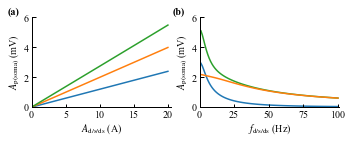

In [4]:
plt.rcParams.update({
    'font.size': 10,  
    'font.family': 'times new roman',
    'mathtext.fontset': 'stix',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic'
})
linewidth = 1
plt.rcParams['xtick.direction'] = 'in'   
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = linewidth
plt.rcParams['ytick.major.width'] = linewidth
colors = ['#247AB7', '#F47E1F', '#30A04A']
fig, ax = plt.subplots(1, 2, figsize=(5, 2))
ax0, ax1 = ax
#############################################################
#############################################################
'''Figure S2(a): 响应幅值依赖于刺激强度'''
addr = ['data/dendSineAmp0-20_Freq10.npz', 'data/somadendSineAmp0-20_Freq10.npz', 'data/somaSineAmp0-20_Freq10.npz']
for tempaddr in addr:
    data = np.load(tempaddr)
    list_AE, list_Ap = data['list_AE'], data['list_Ap']
    ax0.plot(list_AE, list_Ap, lw=1.5)



'''Figure S2(b): 响应幅值依赖于刺激频率'''
addr = ['data/dendSineAmp10_Freq1-100.npz', 'data/somadendSineAmp10_Freq1-100.npz', 'data/somaSineAmp10_Freq1-100.npz']
zorders = [1, 2, 1]
for i, tempaddr in enumerate(addr):
    data = np.load(tempaddr)
    list_fE, list_Ap = data['list_fE'], data['list_Ap']
    ax1.plot(list_fE, list_Ap, lw=1.5, zorder=zorders[i])


#############################################################
#############################################################
ax0.set_xlim(0, 20.5)
ax1.set_xlim(0, 101)
ax0.set_ylim(0, 6)
ax1.set_ylim(0, 6)
ax0.set_xticks(np.arange(0, 21, 5))
ax1.set_xticks(np.arange(0, 101, 25))


ax0.set_xlabel(r'$\mathit{A}_{\mathrm{d/s/ds}}$ (A)', fontsize=10, labelpad=2)
ax0.set_ylabel(r'$\mathit{A}_{\mathrm{p(soma)}}$ (mV)', fontsize=10, labelpad=2)
ax1.set_xlabel(r'$\mathit{f}_{\mathrm{d/s/ds}}$ (Hz)', fontsize=10, labelpad=2)
ax1.set_ylabel(r'$\mathit{A}_{\mathrm{p(soma)}}$ (mV)', fontsize=10, labelpad=2)
for item in [ax0, ax1]:
    item.tick_params(pad=3)
    item.spines['top'].set_color('none')
    item.spines['right'].set_color('none')
    item.spines['bottom'].set_linewidth(linewidth)
    item.spines['left'].set_linewidth(linewidth)
    
plt.tight_layout(w_pad=0.2, h_pad=0.6)
fig.text(0.03, 0.92, '(a)', fontsize=10, fontweight='bold')
fig.text(0.49, 0.92, '(b)', fontsize=10, fontweight='bold')
# plt.savefig(r'C:\Users\Snowp\Desktop\figures\figureS2.tif',format='tif',transparent=True,dpi=400,bbox_inches='tight')
plt.savefig(r'C:\Users\Snowp\Desktop\figures\figureS2.png',format='png',transparent=True,dpi=400,bbox_inches='tight')

# Figure S3:

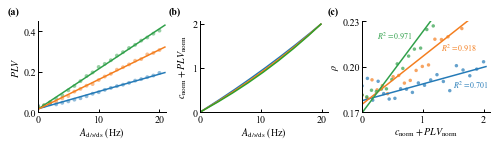

In [5]:
plt.rcParams.update({
    'font.size': 10,  
    'font.family': 'times new roman',
    'mathtext.fontset': 'stix',
    'mathtext.rm': 'Times New Roman',
    'mathtext.it': 'Times New Roman:italic'
})
linewidth = 1
plt.rcParams['xtick.direction'] = 'in'   
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = linewidth
plt.rcParams['ytick.major.width'] = linewidth
colors = ['#247AB7', '#F47E1F', '#30A04A']
fig, ax = plt.subplots(1, 3, figsize=(7, 2))
ax0, ax1, ax2 = ax
#############################################################
#############################################################
list_AE = np.arange(0, 21, 1)
list_fE = np.arange(1, 100, 2)
'''Figure 7(a): 三种条件下的PLV-AE曲线'''
addr = ['data/onlyDendriticSineWave_times40_c03_mu14pA_sigma35pA_AE0-20_fE10.npy',
        'data/SomaticAndDendriticSineWave_times40_c03_mu14pA_sigma35pA_AE0-20_fE10.npy',
        'data/onlySomaticSineWave_times40_c03_mu14pA_sigma35pA_AE0-20_fE10.npy']
zorders = [1, 2, 1]
data_fig7b_norm_plv = []
for i, tempaddr in enumerate(addr):
    data = np.load(tempaddr)
    data = data.squeeze().mean(axis=0).transpose()
    data_plv = data[3]
    x, y = list_AE, data_plv
    init_values = [0.1 for i in range(2)]
    best_vals, covar = curve_fit(poly1fit, x, y, p0=init_values, maxfev = 1000000)
    yfit        = poly1fit(list_AE, *best_vals)
    data_fig7b_norm_plv.append([list_AE, (yfit - yfit.min())/(yfit.max()-yfit.min())])
    xfit        = np.arange(0, 21, 0.1)
    yfit        = poly1fit(xfit, *best_vals)
    ax0.scatter(list_AE, data_plv, marker='o', s=15, color=colors[i], ec=None, alpha=0.5, zorder=-1)
    ax0.plot(xfit, yfit, color=colors[i], zorder=zorders[i], lw=1.5)
ax0.set_ylim(0, 0.45)
#############################################################
#############################################################
'''Figure 7(b): 三种条件下的c+plv —— A曲线'''
data_fig7b_norm_c = []
addr = ['data/dendSineAmp0-20_Freq10.npz', 'data/somadendSineAmp0-20_Freq10.npz', 'data/somaSineAmp0-20_Freq10.npz']
for i, tempaddr in enumerate(addr):
    data = np.load(tempaddr)
    list_AE, list_Ap = data['list_AE'], data['list_Ap']
    yfit   = poly3fit(list_Ap, *[8.916e-7, 1.99e-5, 0.000135, 0.2999])
    data_fig7b_norm_c.append([list_AE, (yfit-yfit.min())/(yfit.max()-yfit.min())])


xfit = np.arange(0, 20, 0.1)
for i in range(3):
    cnorm = np.interp(xfit, data_fig7b_norm_c[i][0], data_fig7b_norm_c[i][1])
    plvnorm = np.interp(xfit, data_fig7b_norm_plv[i][0], data_fig7b_norm_plv[i][1])
    ax1.plot(xfit, cnorm+plvnorm, lw=1.5)

#############################################################
#############################################################
'''Figure 7(c): 三种条件下的ρ-c+plv曲线'''
addr = ['data/onlyDendriticSineWave_times40_c03_mu14pA_sigma35pA_AE0-20_fE10.npy',
        'data/SomaticAndDendriticSineWave_times40_c03_mu14pA_sigma35pA_AE0-20_fE10.npy',
        'data/onlySomaticSineWave_times40_c03_mu14pA_sigma35pA_AE0-20_fE10.npy']
xfit1 = np.arange(-0.05, 2.05, 0.01)
xfit2 = np.arange(-0.05, 1.8, 0.01)
xfit3 = np.arange(-0.05, 1.2, 0.01)
yfit = []
yfit.append(poly1fit(xfit1, *[0.01105, 0.1776]))
yfit.append(poly1fit(xfit2, *[0.03169, 0.1752]))
yfit.append(poly1fit(xfit3, *[0.05367, 0.1696]))
zorders=[1, 2, 1]
xfit = np.arange(0, 21, 1)
for i in range(3):
    data = np.load(addr[i])
    data = data.squeeze().mean(axis=0).transpose()
    data_rou = data[2]
    cnorm = np.interp(xfit, data_fig7b_norm_c[i][0], data_fig7b_norm_c[i][1])
    plvnorm = np.interp(xfit, data_fig7b_norm_plv[i][0], data_fig7b_norm_plv[i][1])
    ax2.scatter(cnorm+plvnorm, data_rou, marker='o', s=12, color=colors[i], ec=None, alpha=0.7, zorder=-1)

ax2.plot(xfit1, yfit[0], color=colors[0], lw=1.5)
ax2.plot(xfit2, yfit[1], color=colors[1], lw=1.5)
ax2.plot(xfit3, yfit[2], color=colors[2], lw=1.5)

ax2.text(1.5, 0.186, r'$R^2=$0.701', fontsize=8, color=colors[0])
ax2.text(1.3, 0.21, r'$R^2=$0.918', fontsize=8, color=colors[1])
ax2.text(0.25, 0.218, r'$R^2=$0.971', fontsize=8, color=colors[2])

#############################################################
#############################################################
ax0.set_xlim(0, 21)
ax1.set_xlim(0, 21)
ax1.set_ylim(0, 2.05)
ax2.set_xlim(0, 2.1)
ax2.set_ylim(0.17, 0.23)
ax2.set_yticks([0.17, 0.20, 0.23])
ax0.set_ylabel(r'$\mathit{PLV}$', fontsize=10, labelpad=2)
ax0.set_xlabel(r'$\mathit{A}_{\mathrm{d/s/ds}}$ (Hz)', fontsize=10, labelpad=2)
ax1.set_xlabel(r'$\mathit{A}_{\mathrm{d/s/ds}}$ (Hz)', fontsize=10, labelpad=2)
ax1.set_ylabel(r'$\mathit{c}_{\mathrm{norm}}+\mathit{PLV}_{\mathrm{norm}}$', fontsize=10, labelpad=4)
ax2.set_ylabel(r'$\rho$', fontsize=10, labelpad=2)
ax2.set_xlabel(r'$\mathit{c}_{\mathrm{norm}}+\mathit{PLV}_{\mathrm{norm}}$', fontsize=10, labelpad=2)

for item in [ax0, ax1, ax2]:
    item.tick_params(pad=2)
    item.spines['top'].set_color('none')
    item.spines['right'].set_color('none')
    item.spines['bottom'].set_linewidth(linewidth)
    item.spines['left'].set_linewidth(linewidth)

plt.tight_layout(w_pad=0.2, h_pad=0)
fig.text(0.015, 0.95, '(a)', fontsize=10, fontweight='bold')
fig.text(0.335, 0.95, '(b)', fontsize=10, fontweight='bold')
fig.text(0.65, 0.95, '(c)', fontsize=10, fontweight='bold')


# plt.savefig(r'C:\Users\Snowp\Desktop\figures\figureS3.tif',format='tif',transparent=True,dpi=400,bbox_inches='tight')
plt.savefig(r'C:\Users\Snowp\Desktop\figures\figureS3.png',format='png',transparent=True,dpi=400,bbox_inches='tight')